## Funciones Implementadas para el EDA

In [1]:
import pandas as pd
import numpy as np

from pandas.api.types import (
    is_numeric_dtype,
    is_datetime64_any_dtype,
)

def classify_columns(df: pd.DataFrame,
                     date_parse_threshold: float = 0.8
                    ) -> dict[str, list[str]]:
    """
    Classify columns into numerical, categorical, and date based on:
      • Date columns: 
        – name contains 'fec' (case-insensitive), OR
        – dtype is datetime64, OR
        – (only if dtype is object) ≥ date_parse_threshold of values parse as dates.
      • Categorical columns:
        – name contains 'id' (case-insensitive), OR
        – strictly binary {0,1}, OR
        – dtype object with any alphabetic character in values.
      • Numerical columns:
        – is_numeric_dtype AND not binary (0/1).
      • Anything else falls back to categorical.
    """
    num_cols, cat_cols, date_cols = [], [], []

    for col in df.columns:
        ser = df[col]
        name = col.lower()

        # 1) Date by name
        if 'fec' in name:
            date_cols.append(col)
            continue

        # 2) Date by dtype
        if is_datetime64_any_dtype(ser):
            date_cols.append(col)
            continue

        # 3) Categorical by name
        if 'id' in name:
            cat_cols.append(col)
            continue

        # 4) Categorical if strictly binary {0,1}
        if is_numeric_dtype(ser):
            uniq = set(ser.dropna().unique())
            if uniq <= {0, 1}:
                cat_cols.append(col)
                continue

        # 5) Object columns: try date‐parse, then alpha check
        if ser.dtype == object:
            # a) Date by parse success rate
            parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
            if parsed.notna().mean() >= date_parse_threshold:
                date_cols.append(col)
                continue

            # b) Categorical if any alphabetic character
            if ser.dropna().astype(str).str.contains(r'[A-Za-z]').any():
                cat_cols.append(col)
                continue

        # 6) Numerical
        if is_numeric_dtype(ser):
            num_cols.append(col)
            continue

        # 7) Fallback to categorical
        cat_cols.append(col)

    return {'num': num_cols, 'cat': cat_cols, 'date': date_cols}
def resumen_general_de_la_base_de_datos(df):
    resumen = pd.DataFrame({
        'Tipo de Dato': df.dtypes,
        'Num_Valores_Únicos': df.nunique(),
        'Num_Valores_Nulos': df.isnull().sum(),
        'Porcentaje_Nulos_(%)': df.isnull().mean() * 100,
        'Valores_No_Nulos': df.notnull().sum()
    })
    return resumen
def resumen_col_categoricas(df,cat_cols, top_n=5):
    resumen = {}
    for col in cat_cols:
        data = df[col]
        resumen[col] = {
            'Num_Valores_Únicos': data.nunique(),
            'Top_Valores_Frecuentes': data.value_counts().head(top_n).to_dict(),
            'Num_Valores_Nulos': data.isnull().sum(),
            'Porcentaje_Nulos_(%)': data.isnull().mean() * 100,
            'Valores_No_Nulos': data.notnull().sum()
        }
    return pd.DataFrame(resumen).T
def resumen_col_numericas(df,num_cols):
    resumen = df[num_cols].describe().T
    resumen["Num_Valores_Nulos"] = df[num_cols].isnull().sum()
    resumen["Porcentaje_Nulos_(%)"] = df[num_cols].isnull().mean() * 100
    
    return resumen


def resumen_col_fechas(df: pd.DataFrame,
                       date_cols: list[str]
                      ) -> pd.DataFrame:
    """
    Para cada columna en date_cols devuelve:
      - Fecha_Mínima, Fecha_Máxima, Rango_Días
      - Num_Valores_Únicos
      - Num_Nulos, Porcentaje_Nulos_(%), Valores_No_Nulos
      - Año_Más_Frecuente, Mes_Más_Frecuente
    
    Detecta fechas en:
      • cadenas ISO (’2020-03-15’, ’15/03/2020’, etc.) mediante infer_datetime_format
      • enteros o cadenas 'YYYYMMDD' (p.ej. 20190816)
    """
    resumen = {}
    for col in date_cols:
        raw = df[col]

        # 1) parse “standard” dates
        dt1 = pd.to_datetime(raw, 
                             errors='coerce', 
                             infer_datetime_format=True)

        # 2) parse YYYYMMDD (ints or strings)
        #    convert everything to str first, strip whitespace
        dt2 = pd.to_datetime(raw.astype(str).str.strip(),
                             format='%Y%m%d',
                             errors='coerce')

        # 3) combine: prefer dt1, but fill its NaT with dt2
        s = dt1.fillna(dt2)

        # now compute your stats
        min_fecha = s.min()
        max_fecha = s.max()
        modo_anos   = s.dt.year.mode()
        modo_meses  = s.dt.month.mode()

        resumen[col] = {
            'Fecha_Mínima'         : min_fecha,
            'Fecha_Máxima'         : max_fecha,
            'Rango_Días'           : (max_fecha - min_fecha).days 
                                     if pd.notna(min_fecha) and pd.notna(max_fecha)
                                     else np.nan,
            'Num_Valores_Únicos'   : int(s.nunique(dropna=True)),
            'Num_Nulos'            : int(s.isnull().sum()),
            'Porcentaje_Nulos_(%)' : float(s.isnull().mean() * 100),
            'Valores_No_Nulos'     : int(s.notnull().sum()),
            'Año_Más_Frecuente'    : int(modo_anos.iloc[0]) 
                                     if not modo_anos.empty else np.nan,
            'Mes_Más_Frecuente'    : int(modo_meses.iloc[0]) 
                                     if not modo_meses.empty else np.nan
        }

    return pd.DataFrame(resumen).T


## FUNCIONES PARA GRAFICAS

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualizar_columnas_por_tipo(df, cols):
    sns.set(style="whitegrid")

    # CATEGÓRICAS (máx 30 categorías)
    for col in cols.get('cat', []):
        if df[col].nunique() <= 30:
            plt.figure(figsize=(10, 4))
            sns.countplot(x=col, data=df, order=df[col].value_counts().index)
            plt.title(f'Conteo de {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # NUMÉRICAS
    for col in cols.get('num', []):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axs[0])
        axs[0].set_title(f'Histograma de {col}')
        sns.boxplot(x=df[col], ax=axs[1])
        axs[1].set_title(f'Boxplot de {col}')
        plt.tight_layout()
        plt.show()

    # FECHAS (ya convertidas correctamente)
    for col in cols.get('date', []):
        s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
        if s.notna().sum() > 0:
            freq = s.dt.to_period("M").value_counts().sort_index()
            freq = freq.rename_axis("Periodo").reset_index(name='Frecuencia')
            freq["Periodo"] = freq["Periodo"].dt.to_timestamp()  # ← esta línea es la clave

            plt.figure(figsize=(10, 4))
            sns.lineplot(x='Periodo', y='Frecuencia', data=freq, marker='o')
            plt.title(f'Frecuencia mensual de {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

## EDA TABLA RESERVACIONES

In [3]:
reservaciones = pd.read_csv("data/iar_Reservaciones.csv", low_memory = False)
reservaciones.head()

,ID_Reserva,Fecha_hoy,h_res_fec,h_res_fec_ok,h_res_fec_okt,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,...,h_edo,h_codigop,h_correo_e,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec,h_ult_cam_fec_ok,h_ult_cam_fec_okt
0,0,8/16/2019 12:00:00 AM,20190816,2019-08-16,8/16/2019 12:00:00 AM,2,0,2,0,0,...,EMX,01500,NaN,NaN,2659.98,0.0,1,20191110,2019-11-10,11/10/2019 12:00:00 AM
1,1,10/22/2019 12:00:00 AM,20191022,2019-10-22,10/22/2019 12:00:00 AM,4,0,4,0,0,...,EGT,023541,NaN,NaN,1764.00,0.0,1,20191205,2019-12-05,12/5/2019 12:00:00 AM
2,2,10/28/2019 12:00:00 AM,20191028,2019-10-28,10/28/2019 12:00:00 AM,2,0,2,0,0,...,EMC,59800,NaN,NaN,2660.04,0.0,1,20191205,2019-12-05,12/5/2019 12:00:00 AM
3,3,10/28/2019 12:00:00 AM,20191028,2019-10-28,10/28/2019 12:00:00 AM,4,0,3,0,0,...,EGT,37219,NaN,NaN,1995.03,0.0,1,20191211,2019-12-11,12/11/2019 12:00:00 AM
4,4,10/28/2019 12:00:00 AM,20191028,2019-10-28,10/28/2019 12:00:00 AM,2,0,2,0,0,...,EMX,15300,NaN,NaN,13369.92,0.0,1,20191212,2019-12-12,12/12/2019 12:00:00 AM


In [4]:
cols = classify_columns(reservaciones)

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see htt

### Clasificación de columnas

In [5]:
print("Columnas Numericas:", cols['num'])
print("Columnas Categoricas::", cols['cat'])
print("Date columns:", cols['date'])

Columnas Numericas: ['h_num_per', 'aa_h_num_per', 'h_num_adu', 'aa_h_num_adu', 'h_num_men', 'aa_h_num_men', 'h_num_noc', 'aa_h_num_noc', 'h_tot_hab', 'aa_h_tot_hab', 'Cliente_Disp', 'aa_Cliente_Disp', 'h_tfa_total', 'aa_h_tfa_total']
Columnas Categoricas:: ['ID_Reserva', 'ID_Programa', 'ID_Paquete', 'ID_Segmento_Comp', 'ID_Agencia', 'ID_empresa', 'ID_Tipo_Habitacion', 'ID_canal', 'ID_Pais_Origen', 'Reservacion', 'aa_Reservacion', 'ID_estatus_reservaciones', 'h_can_res', 'h_cod_reserva', 'h_edo', 'h_codigop', 'h_correo_e', 'h_nom', 'moneda_cve']
Date columns: ['Fecha_hoy', 'h_res_fec', 'h_res_fec_ok', 'h_res_fec_okt', 'h_fec_lld', 'h_fec_lld_ok', 'h_fec_lld_okt', 'h_fec_reg', 'h_fec_reg_ok', 'h_fec_reg_okt', 'h_fec_sda', 'h_fec_sda_ok', 'h_fec_sda_okt', 'h_ult_cam_fec', 'h_ult_cam_fec_ok', 'h_ult_cam_fec_okt']


### Resumen General de la tabla

In [6]:
resumen=resumen_general_de_la_base_de_datos(reservaciones)
resumen

,Tipo de Dato,Num_Valores_Únicos,Num_Valores_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos
ID_Reserva,int64,203002,0,0.0,203002
Fecha_hoy,object,824,0,0.0,203002
h_res_fec,int64,482,0,0.0,203002
h_res_fec_ok,object,482,0,0.0,203002
h_res_fec_okt,object,482,0,0.0,203002
h_num_per,int64,22,0,0.0,203002
aa_h_num_per,int64,22,0,0.0,203002
h_num_adu,int64,16,0,0.0,203002
aa_h_num_adu,int64,16,0,0.0,203002
h_num_men,int64,10,0,0.0,203002


### Resumen columnas categoricas

In [7]:
resumen_categoricas=resumen_col_categoricas(reservaciones,cols['cat'], top_n=5)
resumen_categoricas

,Num_Valores_Únicos,Top_Valores_Frecuentes,Num_Valores_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos
ID_Reserva,203002,"{0: 1, 135326: 1, 135328: 1, 135329: 1, 135330...",0,0.0,203002
ID_Programa,2,"{1: 202510, 0: 492}",0,0.0,203002
ID_Paquete,6,"{1: 117658, 2: 84718, 0: 492, 5: 92, 3: 40}",0,0.0,203002
ID_Segmento_Comp,20,"{17: 73098, 14: 27298, 5: 26874, 16: 16872, 12...",0,0.0,203002
ID_Agencia,120,"{99: 31553, 112: 25735, 86: 13031, 14: 12337, ...",0,0.0,203002
ID_empresa,1,{1: 203002},0,0.0,203002
ID_Tipo_Habitacion,28,"{4: 52796, 19: 51281, 17: 30868, 6: 13910, 25:...",0,0.0,203002
ID_canal,14,"{1: 82255, 4: 80877, 10: 19743, 7: 6805, 0: 6378}",0,0.0,203002
ID_Pais_Origen,4,"{157: 201504, 0: 646, 232: 624, 38: 228}",0,0.0,203002
Reservacion,2,"{1: 102199, 0: 100803}",0,0.0,203002


### Resumen columnas numericas

In [8]:
resumen_numericas=resumen_col_numericas(reservaciones,cols['num'])
resumen_numericas

,count,mean,std,min,25%,50%,75%,max,Num_Valores_Nulos,Porcentaje_Nulos_(%)
h_num_per,203002.0,1.185865,1.369629,0.0,0.0,1.0,2.0,32.0,0,0.0
aa_h_num_per,203002.0,1.170550,1.368073,0.0,0.0,0.0,2.0,32.0,0,0.0
h_num_adu,203002.0,1.094708,1.207076,0.0,0.0,1.0,2.0,15.0,0,0.0
aa_h_num_adu,203002.0,1.079694,1.204694,0.0,0.0,0.0,2.0,15.0,0,0.0
h_num_men,203002.0,0.034108,0.265187,0.0,0.0,0.0,0.0,15.0,0,0.0
aa_h_num_men,203002.0,0.033734,0.264043,0.0,0.0,0.0,0.0,15.0,0,0.0
h_num_noc,203002.0,1.680028,2.866189,0.0,0.0,1.0,3.0,687.0,0,0.0
aa_h_num_noc,203002.0,1.656043,2.847958,0.0,0.0,0.0,3.0,687.0,0,0.0
h_tot_hab,203002.0,0.505581,0.508751,0.0,0.0,1.0,1.0,6.0,0,0.0
aa_h_tot_hab,203002.0,0.498586,0.508489,0.0,0.0,0.0,1.0,6.0,0,0.0


### Resumen columnas fechas

In [9]:
resumen_fechas=resumen_col_fechas(reservaciones,cols['date'])
resumen_fechas

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:124: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt1 = pd.to_datetime(raw,
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:124: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt1 = pd.to_datetime(raw,
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:124: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove 

,Fecha_Mínima,Fecha_Máxima,Rango_Días,Num_Valores_Únicos,Num_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos,Año_Más_Frecuente,Mes_Más_Frecuente
Fecha_hoy,2019-01-02 00:00:00,2021-04-04 00:00:00,823,824,0,0.0,203002,2020,2
h_res_fec,1970-01-01 00:00:00.020190102,1970-01-01 00:00:00.020200430,0,482,0,0.0,203002,1970,1
h_res_fec_ok,2019-01-02 00:00:00,2020-04-30 00:00:00,484,482,0,0.0,203002,2019,2
h_res_fec_okt,2019-01-02 00:00:00,2020-04-30 00:00:00,484,482,0,0.0,203002,2019,2
h_fec_lld,2019-02-05 00:00:00,2021-12-02 00:00:00,1031,713,2,0.000985,203000,2019,5
h_fec_lld_ok,2000-01-01 00:00:00,2021-12-02 00:00:00,8006,714,0,0.0,203002,2019,5
h_fec_lld_okt,2000-01-01 00:00:00,2021-12-02 00:00:00,8006,714,0,0.0,203002,2019,5
h_fec_reg,2019-01-02 00:00:00,2020-07-13 00:00:00,558,514,1550,0.763539,201452,2019,3
h_fec_reg_ok,2000-01-01 00:00:00,2020-07-13 00:00:00,7499,515,0,0.0,203002,2019,3
h_fec_reg_okt,2000-01-01 00:00:00,2020-07-13 00:00:00,7499,515,0,0.0,203002,2019,3


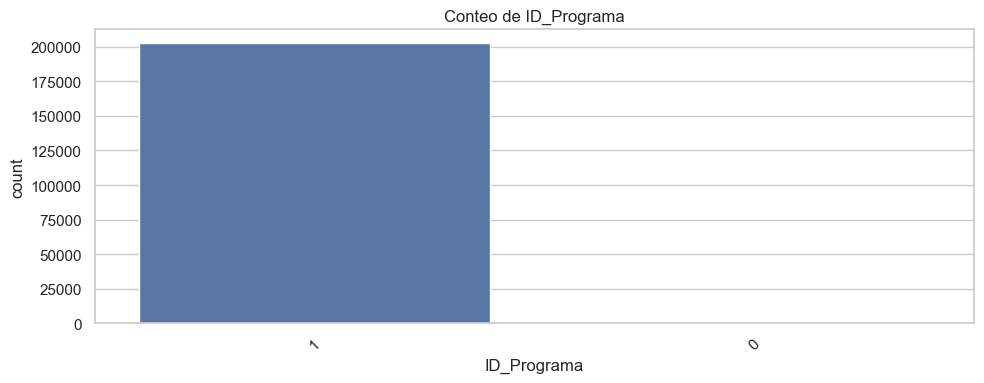

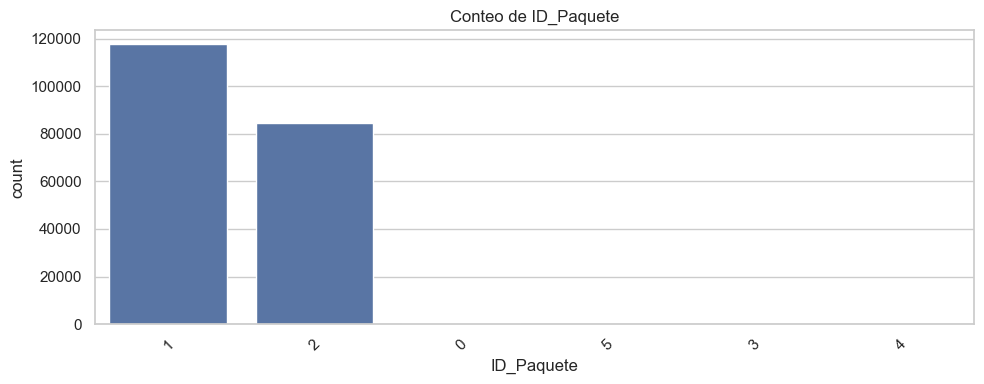

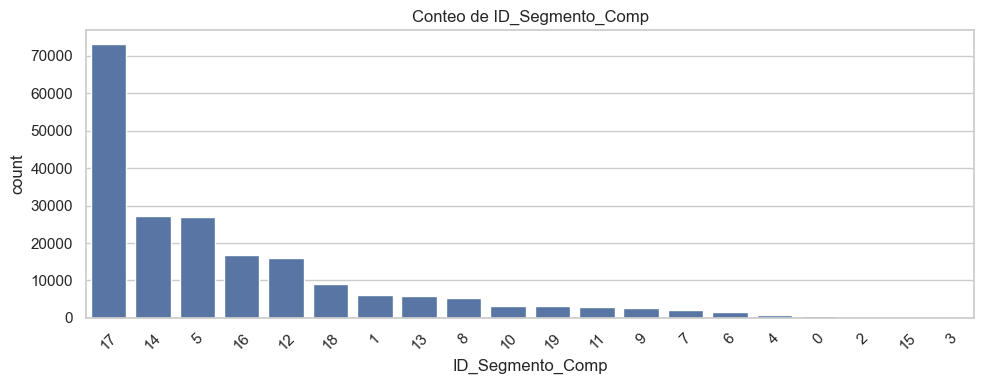

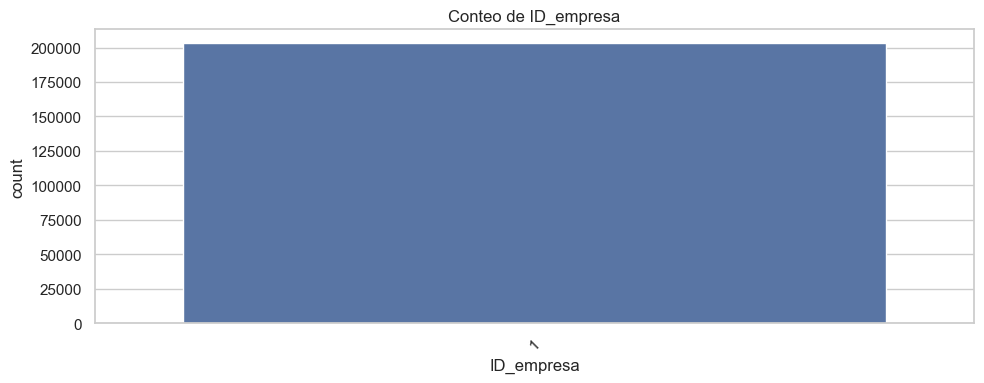

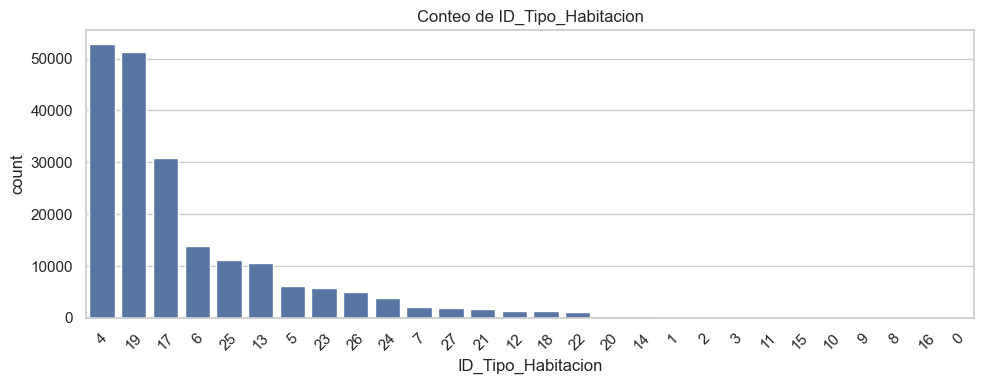

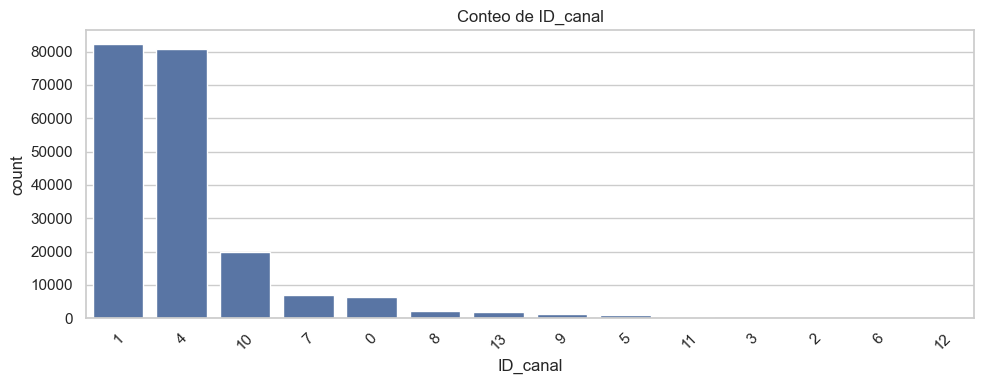

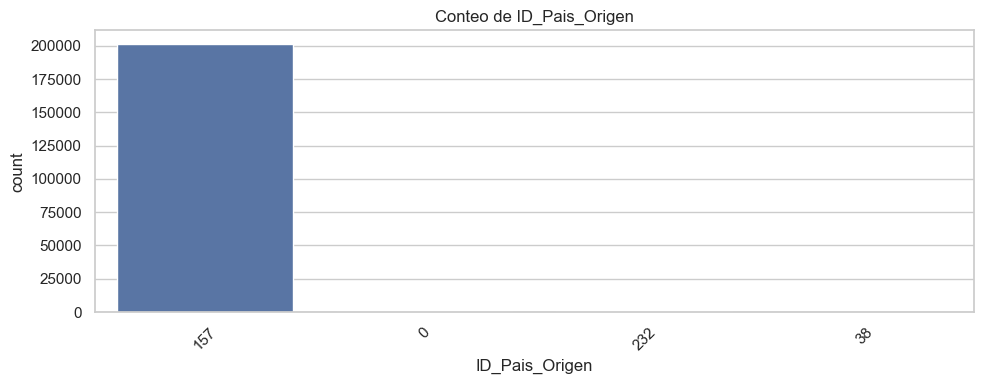

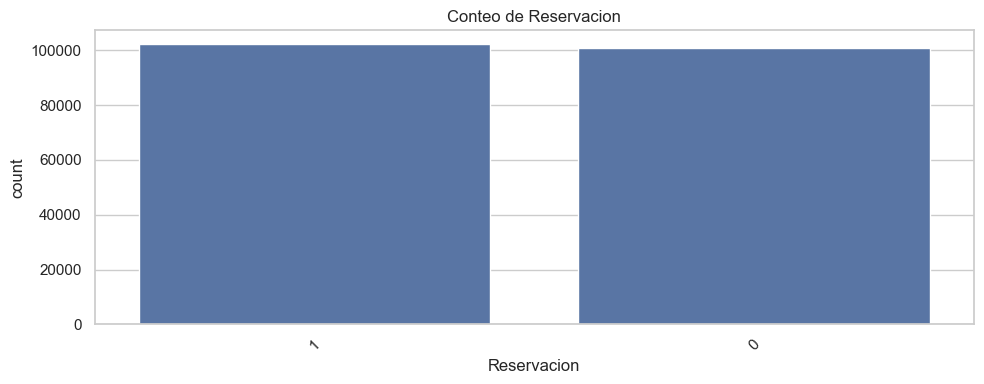

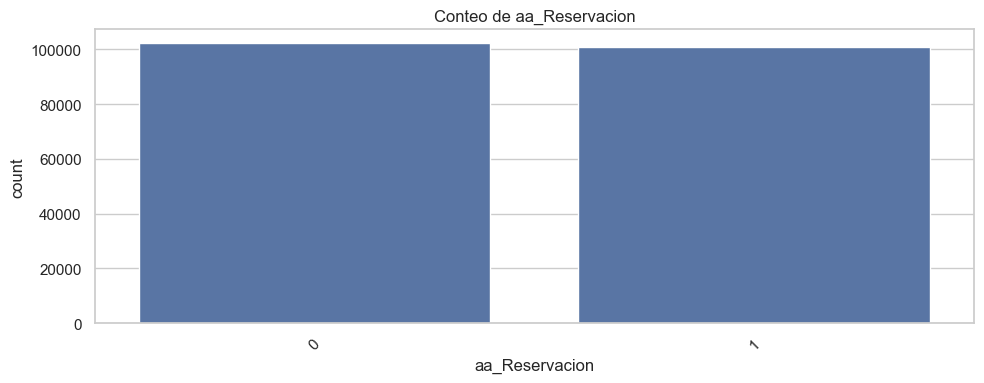

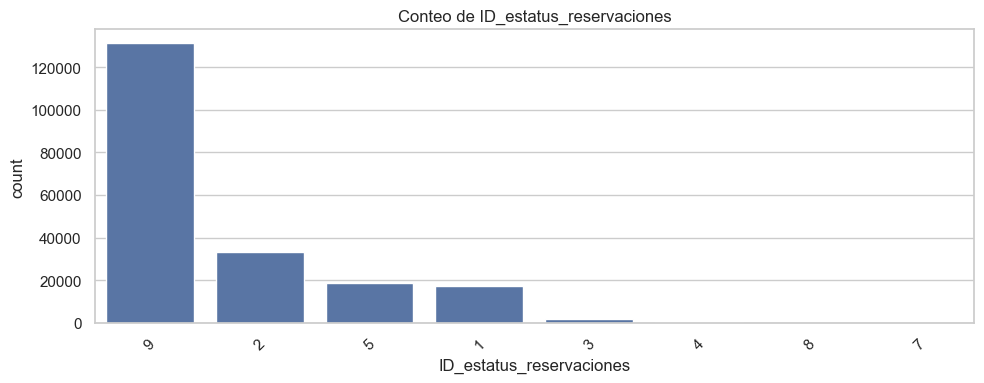

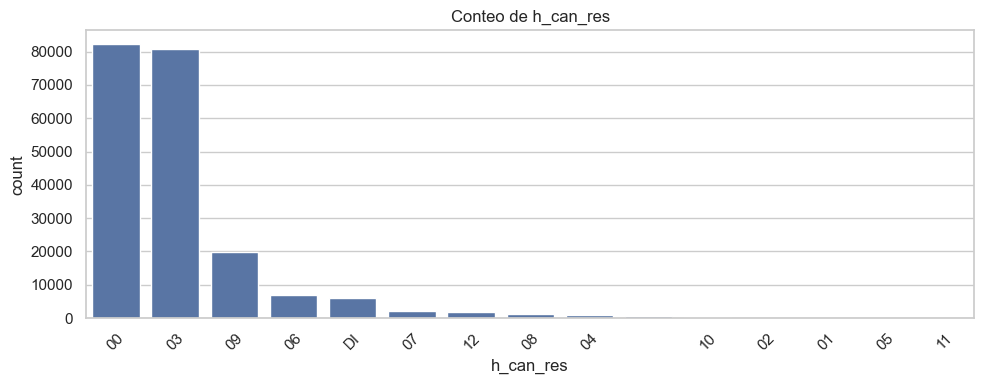

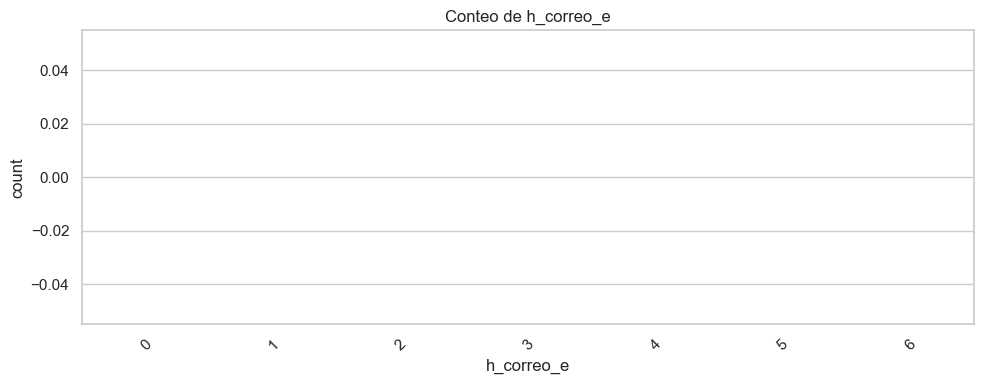

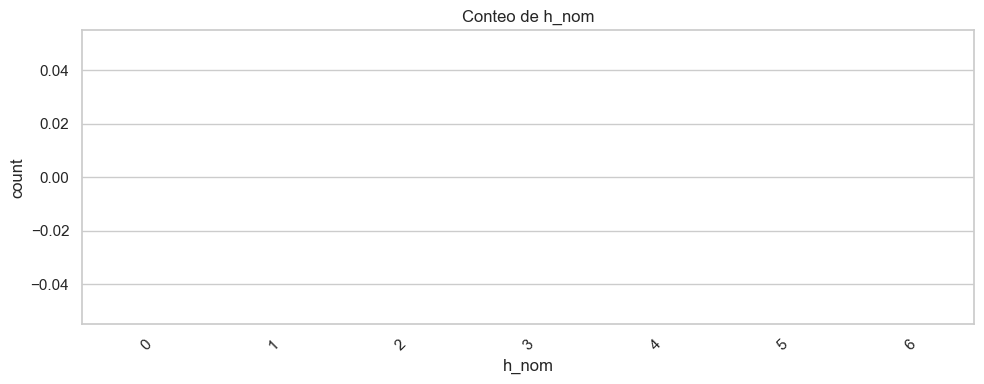

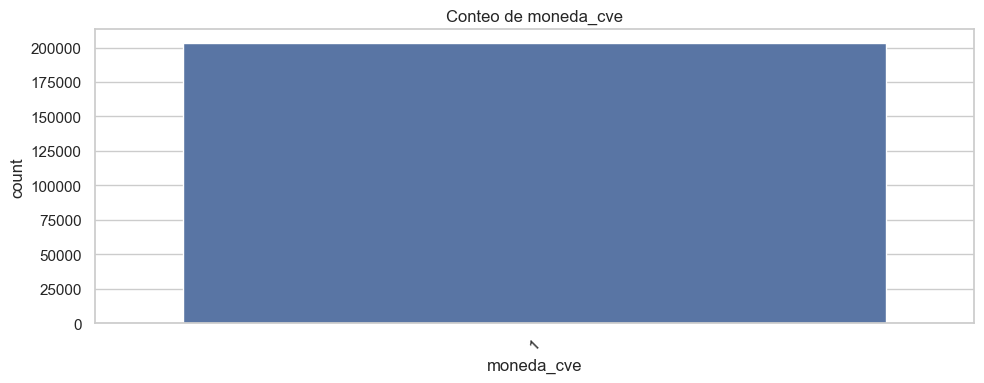

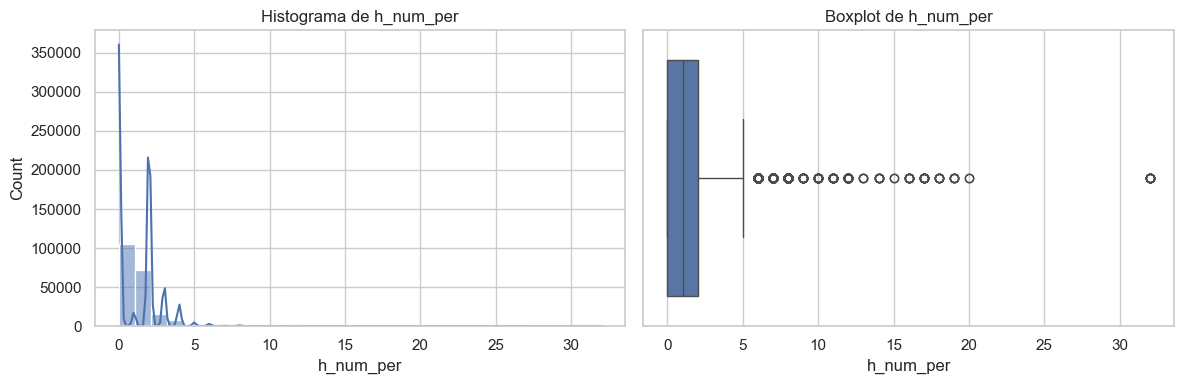

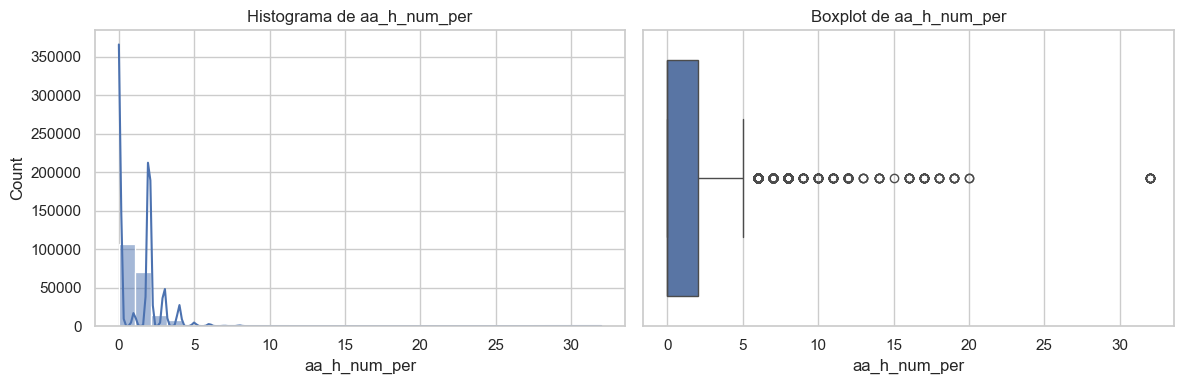

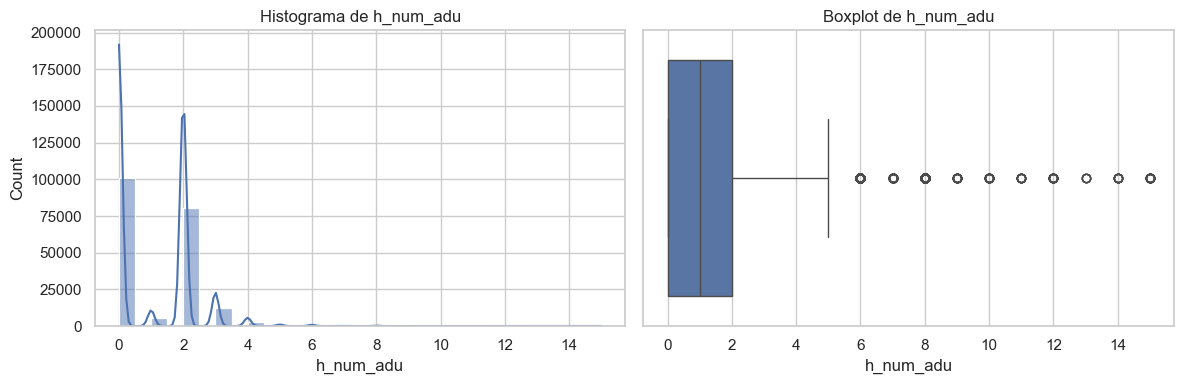

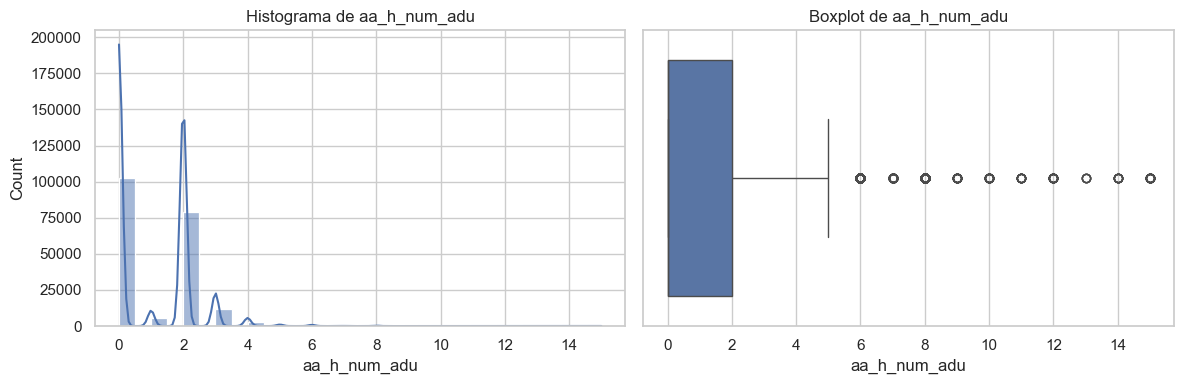

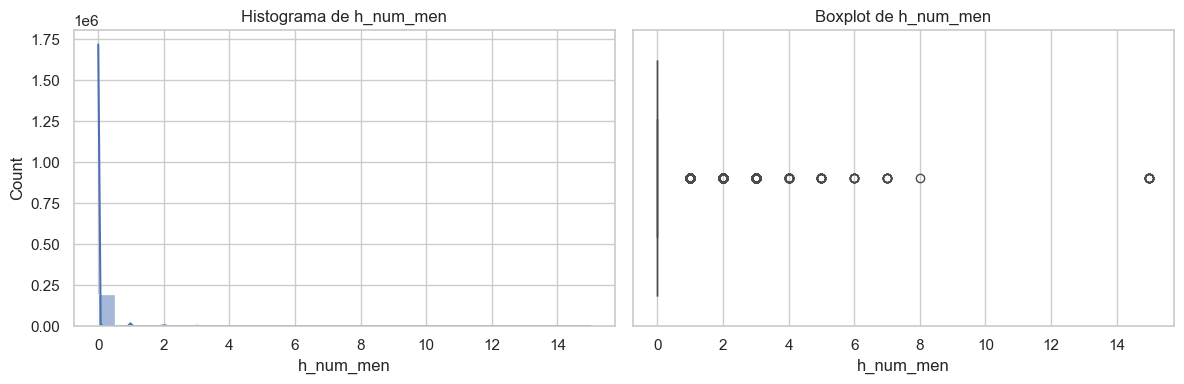

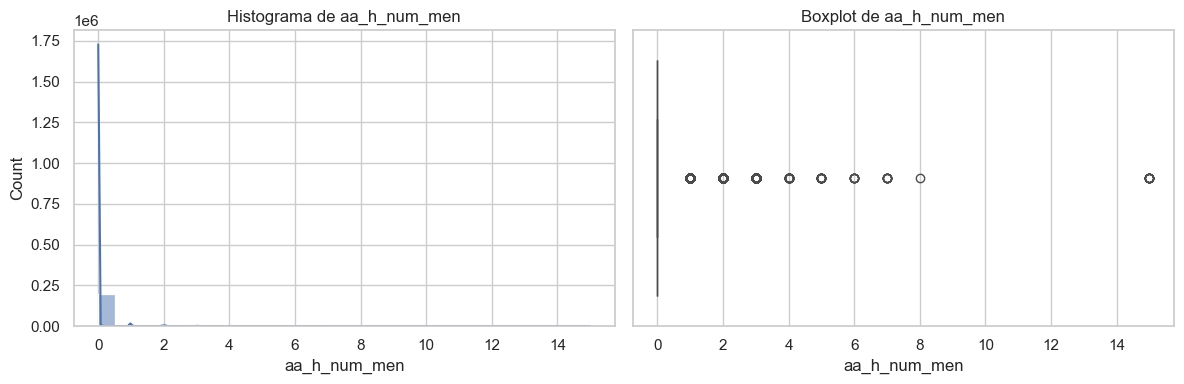

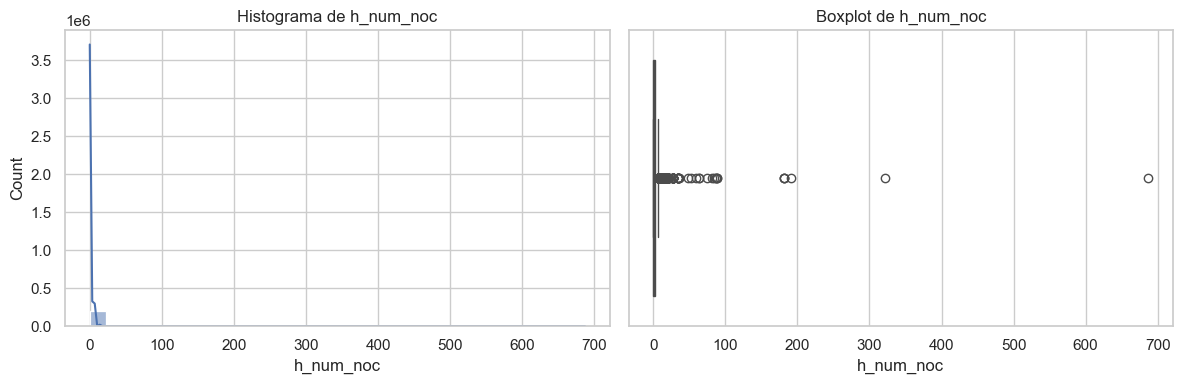

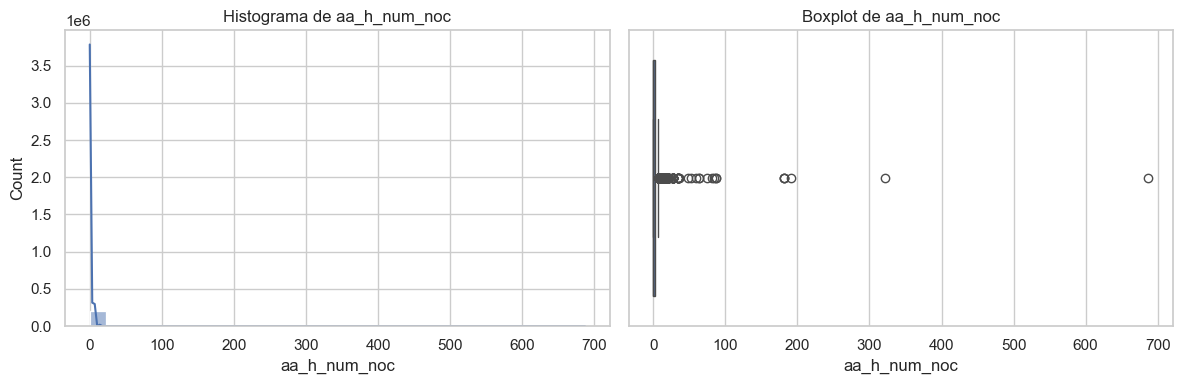

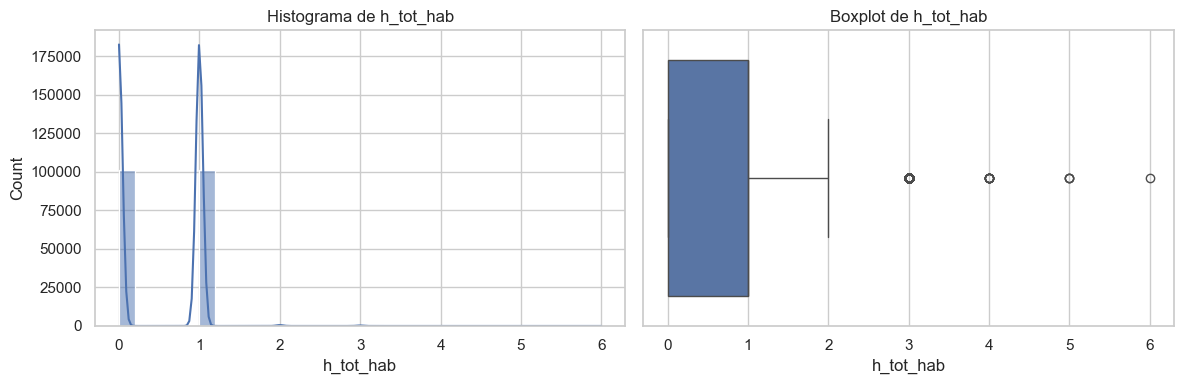

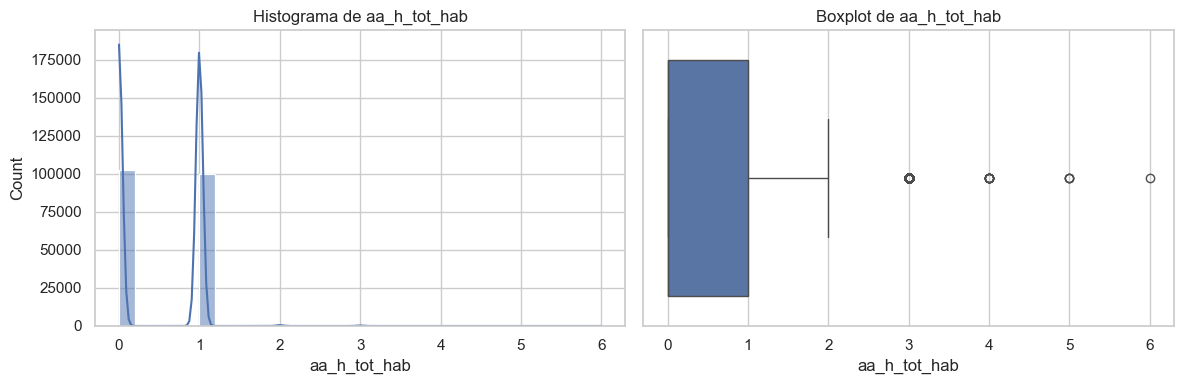

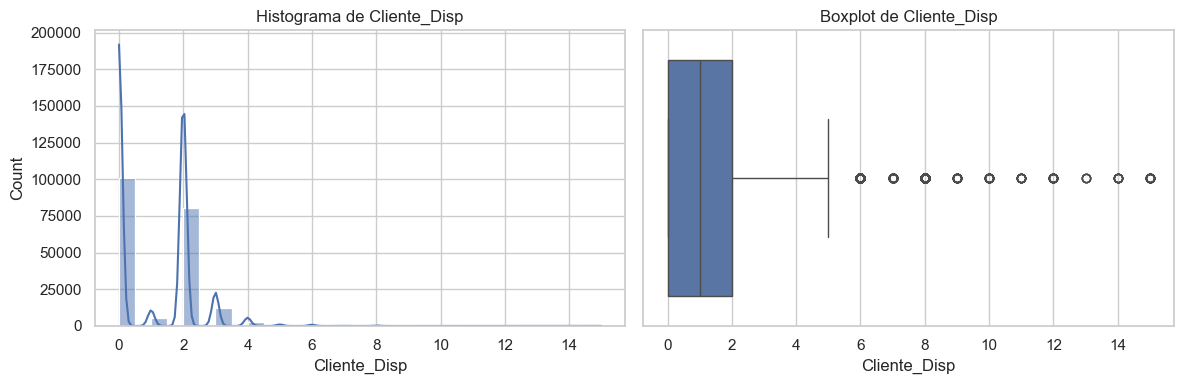

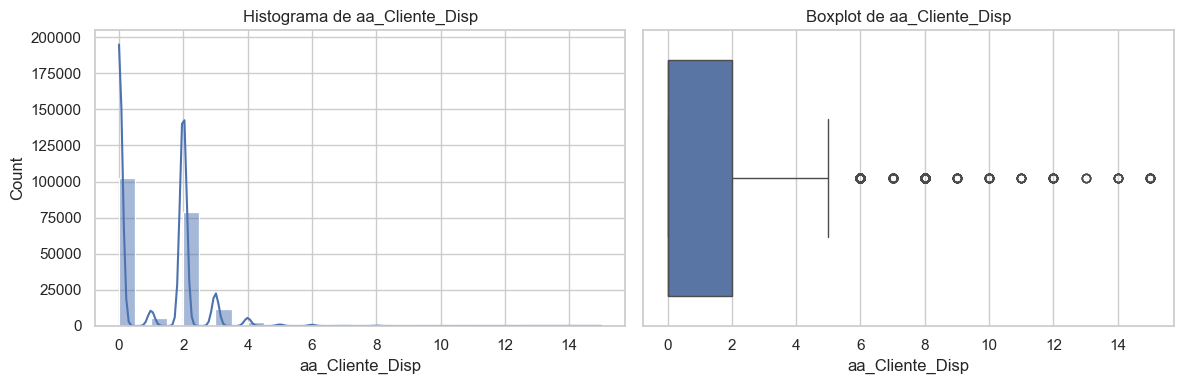

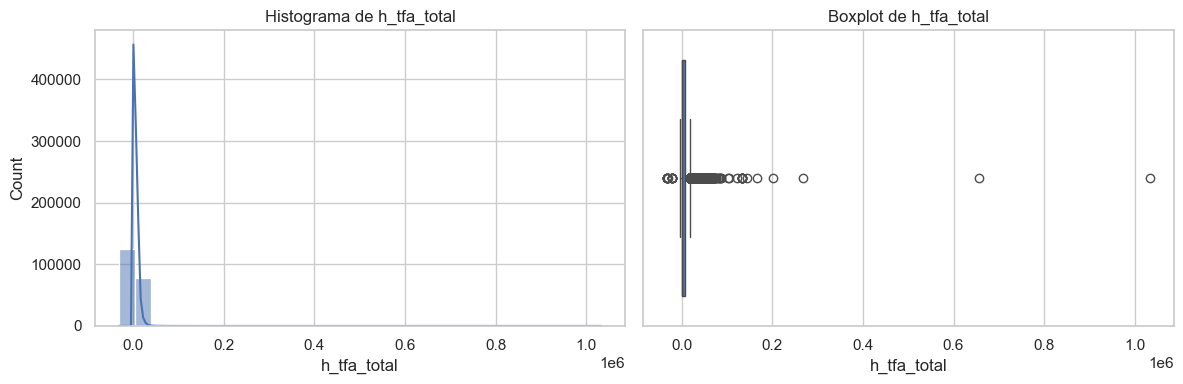

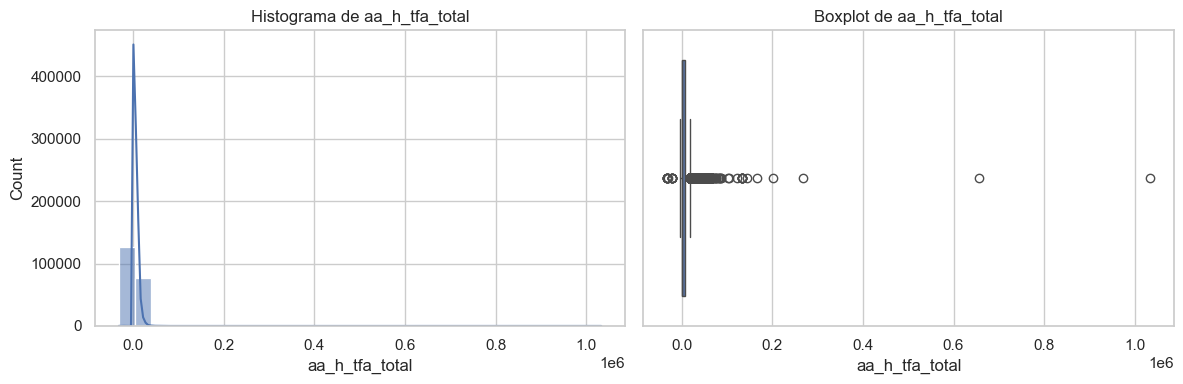

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


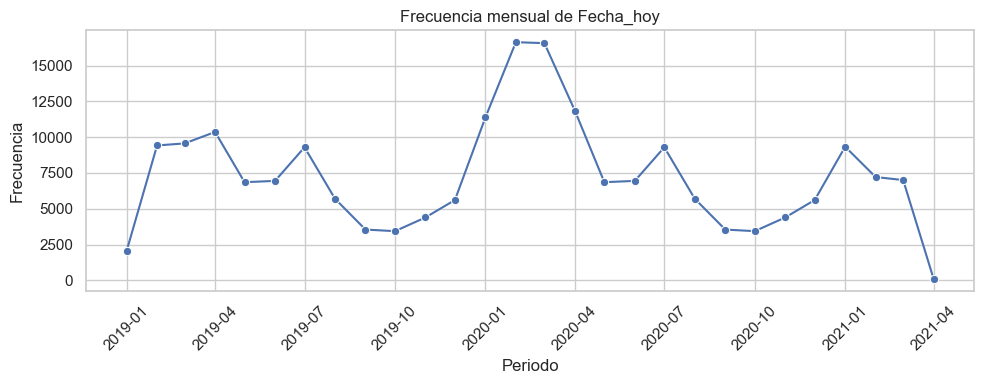

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


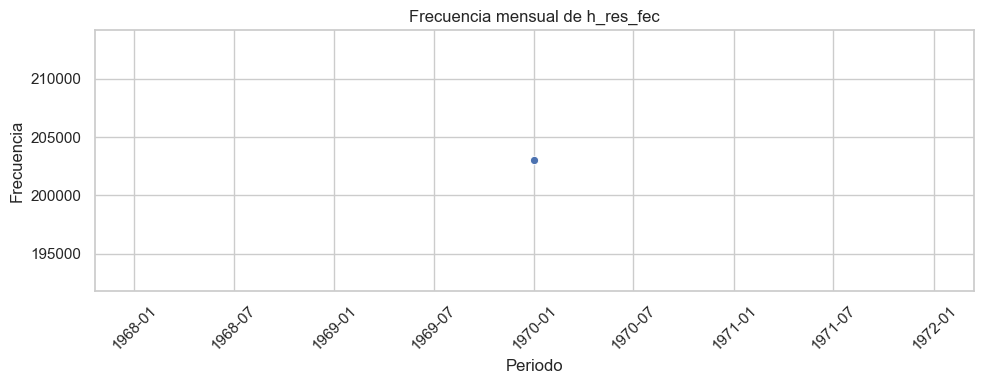

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


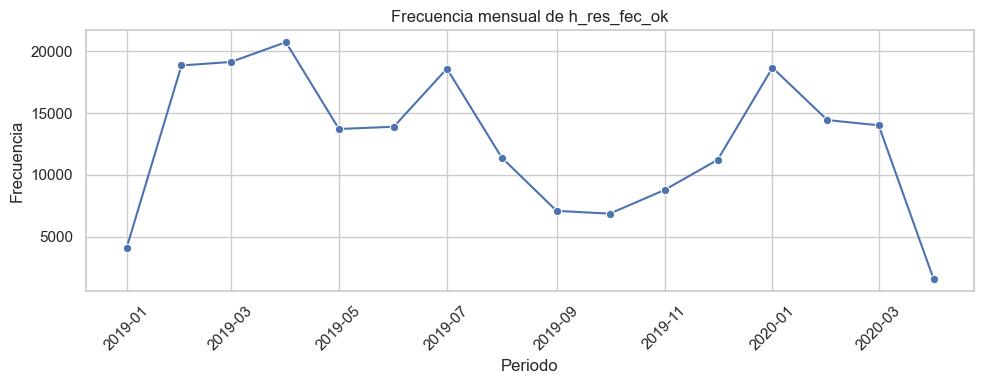

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


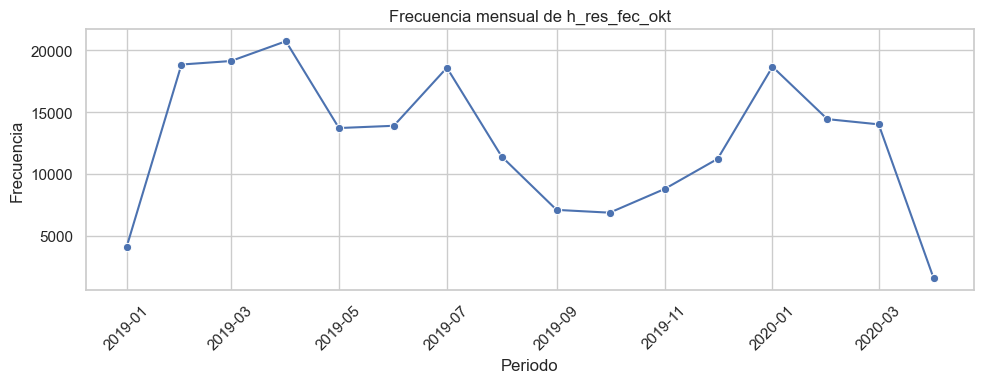

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


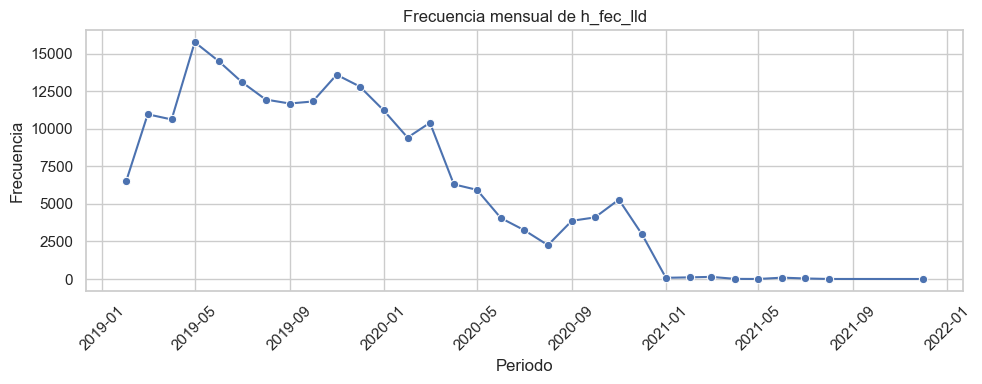

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


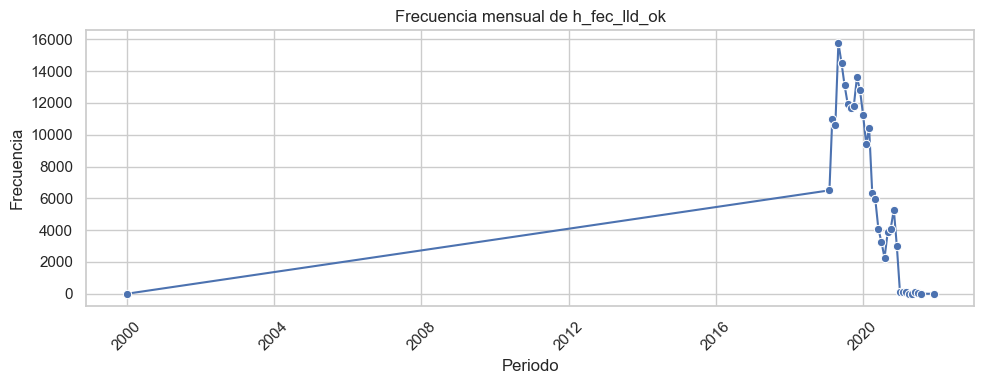

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


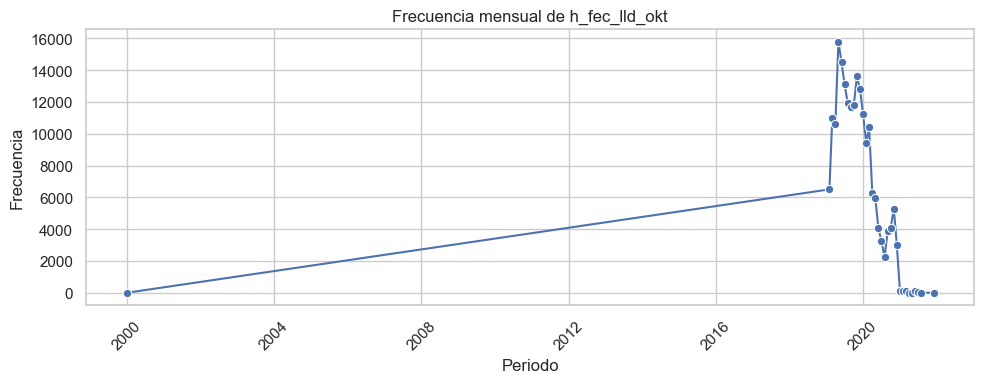

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


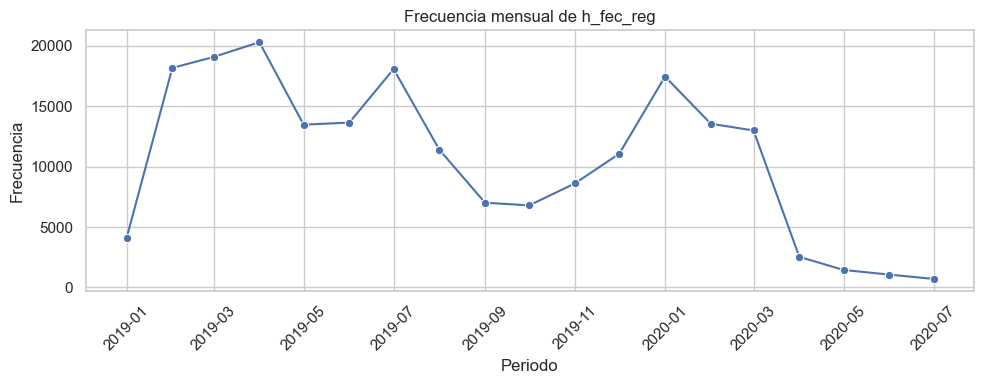

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


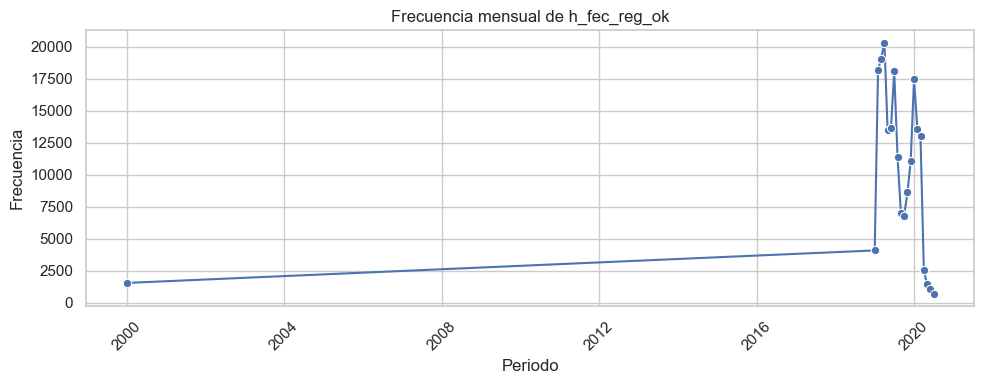

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


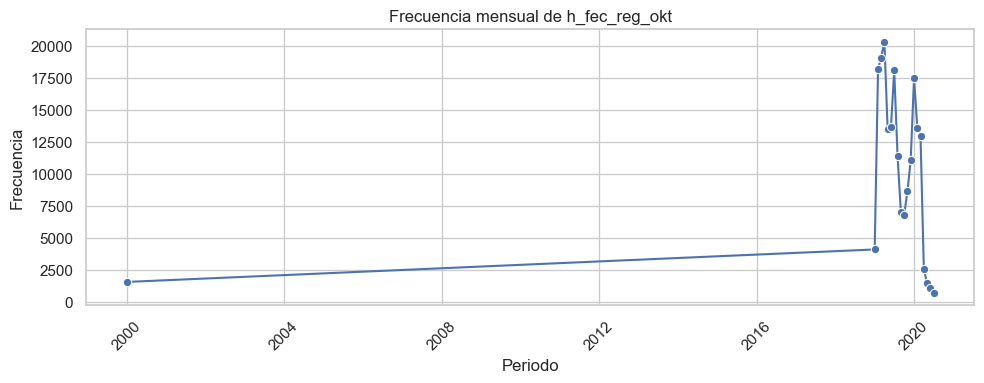

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


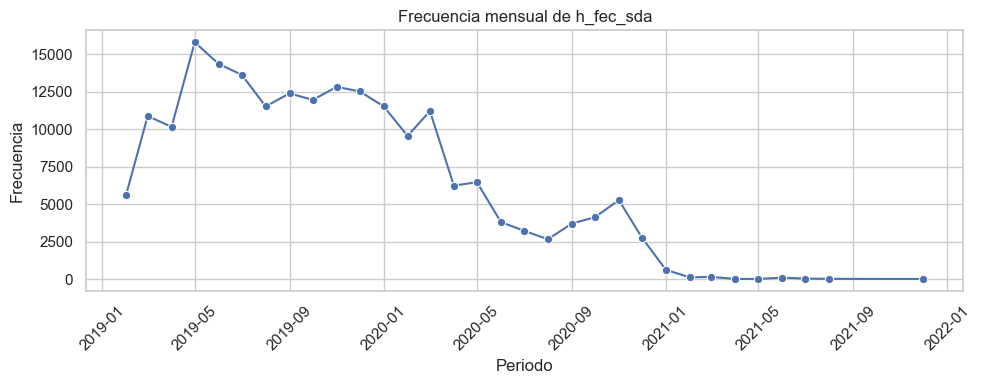

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


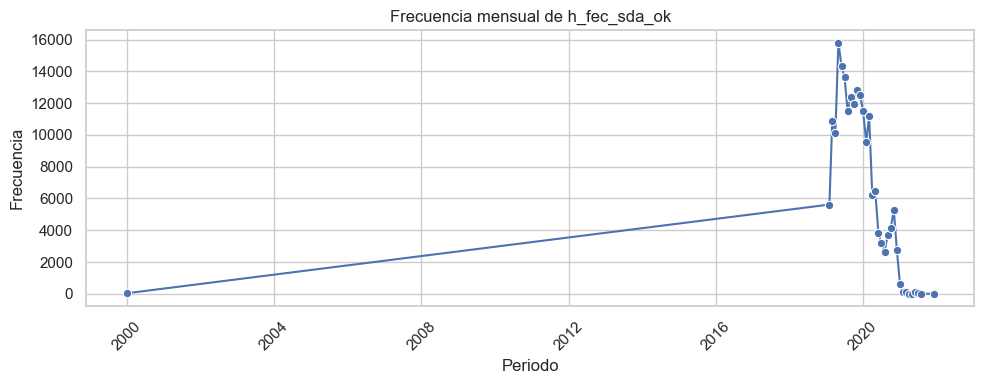

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


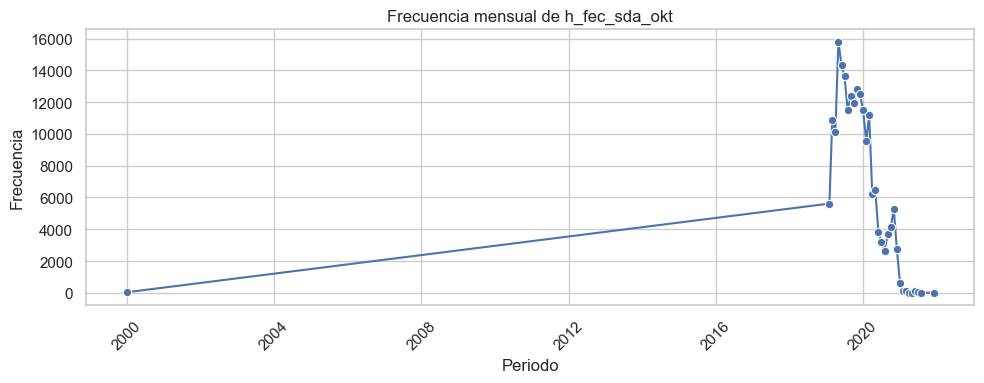

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


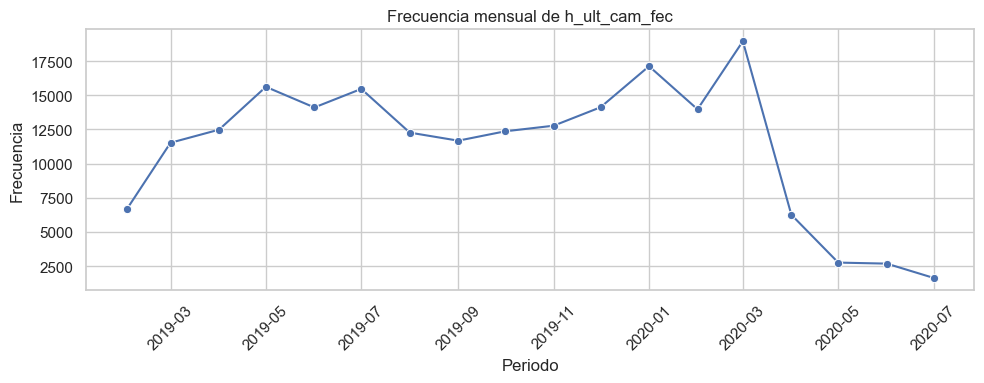

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


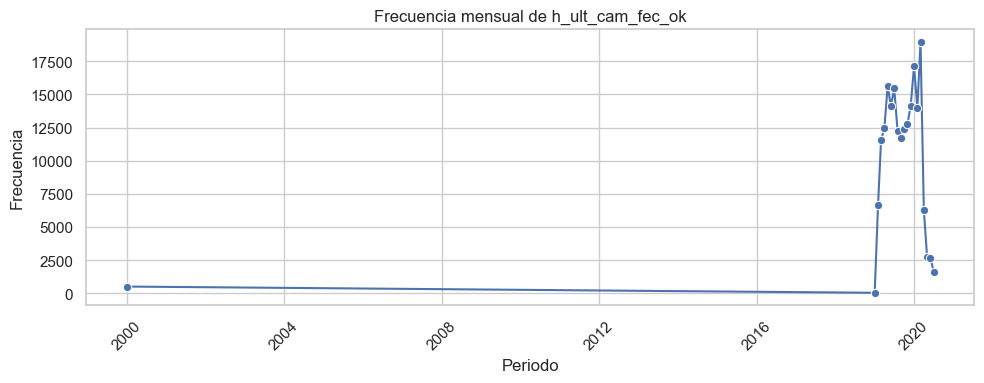

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


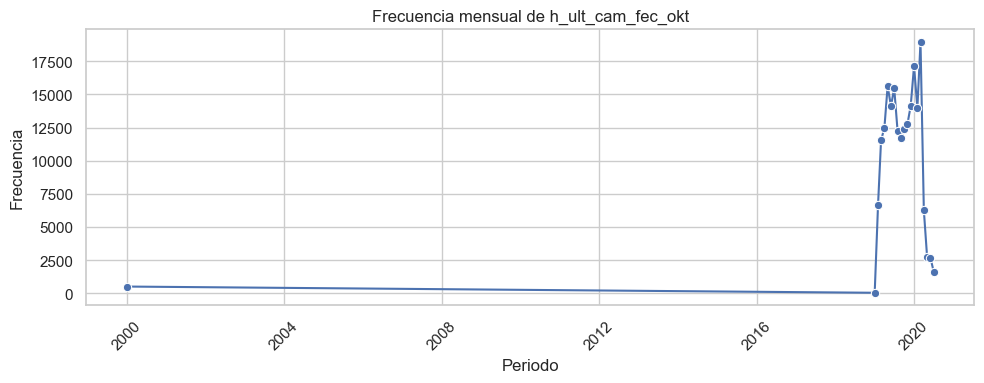

In [12]:
visualizar_columnas_por_tipo(reservaciones, cols)

## EDA PLATILLOS

In [13]:
platillos= pd.read_csv("data/iaab_Platillos.csv", low_memory = False)

In [14]:
platillos

,ID_Platillo,Platillo_cve,Platillo_Nombre,Clasif_cve,Clasif_nombre
0,0,|,PLATILLO,|,SIN DEFINIR
1,1,PAQHD,PAQUETES,AB,ALIMENTOS Y BEBIDAS
2,2,DSCALI,DESCUENTO ALIMENTOS,|,SIN DEFINIR
3,3,DSCBEB,DESCUENTO BEBIDAS,|,SIN DEFINIR
4,4,DSCOTR,DESCUENTO OTROS,|,SIN DEFINIR
...,...,...,...,...,...
982,982,ROOMG4,ALIM BABY SHOWER ROSY TAPIA,|,SIN DEFINIR
983,983,ROOMG5,BEBI BABY SHOWER ROSY TAPIA,|,SIN DEFINIR
984,984,ENTO15,ADEREZO BALSAMICO ESPE,OV,OLIVO Y VID
985,985,ENTO16,TARTARA,OV,OLIVO Y VID


In [15]:
cols = classify_columns(platillos)

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see htt

### Clasificación de columnas

In [16]:
print("Columnas Numericas:", cols['num'])
print("Columnas Categoricas::", cols['cat'])
print("Date columns:", cols['date'])

Columnas Numericas: []
Columnas Categoricas:: ['ID_Platillo', 'Platillo_cve', 'Platillo_Nombre', 'Clasif_cve', 'Clasif_nombre']
Date columns: []


### Resumen General de la tabla

In [17]:
resumen=resumen_general_de_la_base_de_datos(platillos)
resumen

,Tipo de Dato,Num_Valores_Únicos,Num_Valores_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos
ID_Platillo,int64,987,0,0.0,987
Platillo_cve,object,987,0,0.0,987
Platillo_Nombre,object,806,0,0.0,987
Clasif_cve,object,18,0,0.0,987
Clasif_nombre,object,18,0,0.0,987


### Resumen columnas categoricas

In [18]:
resumen_categoricas=resumen_col_categoricas(platillos,cols['cat'], top_n=5)
resumen_categoricas

,Num_Valores_Únicos,Top_Valores_Frecuentes,Num_Valores_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos
ID_Platillo,987,"{0: 1, 648: 1, 650: 1, 651: 1, 652: 1}",0,0.0,987
Platillo_cve,987,"{'|': 1, 'PLFO09': 1, 'POSO07': 1, 'PLFO11': 1...",0,0.0,987
Platillo_Nombre,806,"{' ': 23, 'REFRESCO ...",0,0.0,987
Clasif_cve,18,"{'BA ': 262, '|': 183, 'OV ': 63, 'RA ...",0,0.0,987
Clasif_nombre,18,"{'BANQUETES': 262, 'SIN DEFINIR': 183, 'OLIVO ...",0,0.0,987


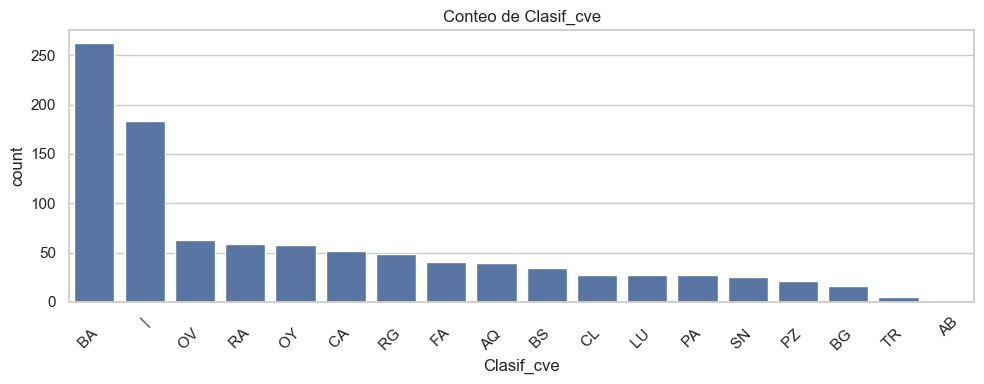

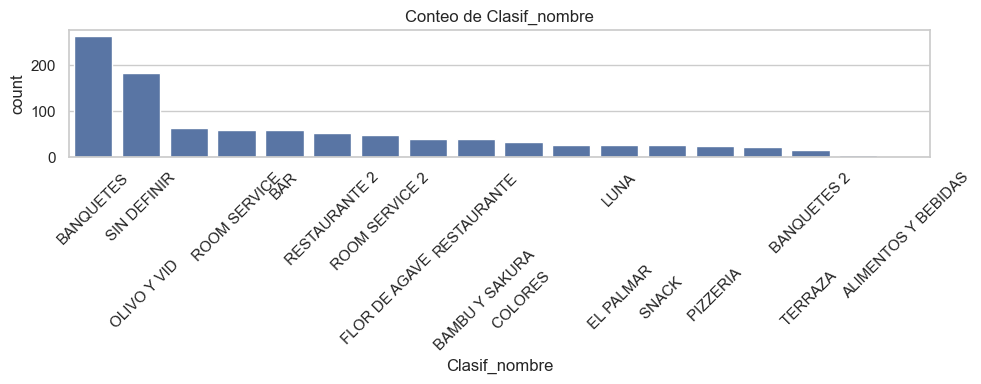

In [19]:
visualizar_columnas_por_tipo(platillos, cols)

## EDA Tabla Detalles Ventas

In [20]:
detallesVtas = pd.read_csv("data/iaab_Detalles_Vtas.csv",low_memory = False)


In [21]:
detallesVtas.head()

,ID_Detalle_vta,fecha_hoy,caja_cve,turno_cve,ID_status,fec_com,hora_alta,folio,mesero,id_operador,...,ID_empresa,ID_Map_tipo_bebyali,impto,aa_impto,Total_Sin_Impuestos,aa_total_s_impto,moneda_cve,ID_tipo_venta,ID_map_status,ID_tipo_cheque
0,223675,9/26/2018 12:00:00 AM,1,1,1,20180926,92400,12615,AL0,329,...,3,1,1,0,5.118750,0,2,0,2,1
1,223676,9/26/2018 12:00:00 AM,1,1,1,20180926,92400,12615,AL0,329,...,3,1,1,0,7.543125,0,2,0,2,1
2,223677,9/26/2018 12:00:00 AM,1,1,1,20180926,102900,12624,AL0,329,...,3,1,1,0,23.437500,0,2,0,2,2
3,223678,9/26/2018 12:00:00 AM,1,1,1,20180926,102900,12624,AL0,329,...,3,1,1,0,5.118750,0,2,0,2,2
4,223679,9/26/2018 12:00:00 AM,1,1,2,20180926,102900,12624,AL0,329,...,3,1,1,0,-5.711250,0,2,0,2,2


In [22]:
cols = classify_columns(detallesVtas)

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(ser, errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see htt

### Clasificación de columnas

In [23]:
print("Columnas Numericas:", cols['num'])
print("Columnas Categoricas::", cols['cat'])
print("Date columns:", cols['date'])

Columnas Numericas: ['caja_cve', 'turno_cve', 'hora_alta', 'folio', 'importe', 'importe_ali', 'importe_beb', 'monto_total', 'HORA_MIN_SEG', 'HORA_MIN_SEG_sda', 'impto', 'Total_Sin_Impuestos', 'moneda_cve']
Columnas Categoricas:: ['ID_Detalle_vta', 'ID_status', 'mesero', 'id_operador', 'platillo_cve', 'cantidad', 'aa_cantidad', 'cantidad_ali', 'aa_cantidad_ali', 'cantidad_beb', 'aa_cantidad_beb', 'cantidad_che_ali', 'aa_cantidad_che_ali', 'cantidad_che_beb', 'aa_cantidad_che_beb', 'aa_importe', 'aa_importe_ali', 'aa_importe_beb', 'aa_monto_total', 'ID_Map_turno', 'ID_Caja', 'ID_Platillo', 'tipo', 'ID_Tipo_Mvto', 'id_date', 'id_date_sda', 'domingo', 'lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'ID_empresa', 'ID_Map_tipo_bebyali', 'aa_impto', 'aa_total_s_impto', 'ID_tipo_venta', 'ID_map_status', 'ID_tipo_cheque']
Date columns: ['fecha_hoy', 'fec_com']


### Resumen General de la tabla

In [24]:
resumen=resumen_general_de_la_base_de_datos(detallesVtas)
resumen

,Tipo de Dato,Num_Valores_Únicos,Num_Valores_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos
ID_Detalle_vta,int64,1672428,0,0.0,1672428
fecha_hoy,object,1106,0,0.0,1672428
caja_cve,int64,14,0,0.0,1672428
turno_cve,int64,4,0,0.0,1672428
ID_status,int64,5,0,0.0,1672428
fec_com,int64,1105,0,0.0,1672428
hora_alta,int64,1434,0,0.0,1672428
folio,int64,64720,0,0.0,1672428
mesero,object,362,0,0.0,1672428
id_operador,int64,354,0,0.0,1672428


### Resumen columnas categoricas

In [25]:
resumen_categoricas=resumen_col_categoricas(detallesVtas,cols['cat'], top_n=5)
resumen_categoricas

,Num_Valores_Únicos,Top_Valores_Frecuentes,Num_Valores_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos
ID_Detalle_vta,1672428,"{223675: 1, 1113292: 1, 1113302: 1, 1113301: 1...",0,0.0,1672428
ID_status,5,"{1: 1516060, 2: 144124, 4: 6934, 3: 3586, 0: 1...",0,0.0,1672428
mesero,362,"{'BLG': 156960, 'CAP': 131642, 'AL0': 101978, ...",0,0.0,1672428
id_operador,354,"{330: 156960, 383: 131642, 329: 101978, 321: 1...",0,0.0,1672428
platillo_cve,1119,"{'DSCALI ': 100448, 'BUF011 ': 93318, 'REF00...",0,0.0,1672428
cantidad,608,"{1.0: 987406, 2.0: 273104, 0.0: 161900, 3.0: 6...",0,0.0,1672428
aa_cantidad,1,{0: 1672428},0,0.0,1672428
cantidad_ali,435,"{0.0: 797730, 1.0: 577182, 2.0: 154736, 3.0: 3...",0,0.0,1672428
aa_cantidad_ali,1,{0: 1672428},0,0.0,1672428
cantidad_beb,381,"{0.0: 1085576, 1.0: 391314, 2.0: 109842, 3.0: ...",0,0.0,1672428


### Resumen columnas numericas

In [26]:
resumen_numericas=resumen_col_numericas(detallesVtas,cols['num'])
resumen_numericas

,count,mean,std,min,25%,50%,75%,max,Num_Valores_Nulos,Porcentaje_Nulos_(%)
caja_cve,1672428.0,3.654930,4.899333,1.000000,1.000000,1.000000,5.000000,92.00,0,0.0
turno_cve,1672428.0,2.001356,0.800854,1.000000,1.000000,2.000000,3.000000,4.00,0,0.0
hora_alta,1672428.0,156914.793821,45386.686846,0.000000,120200.000000,161800.000000,195000.000000,235900.00,0,0.0
folio,1672428.0,18319.188783,16917.004275,1.000000,3786.000000,13255.000000,29981.000000,64836.00,0,0.0
importe,1672428.0,144.201671,2128.171235,-375916.034483,5.017333,38.793103,107.758621,686415.00,0,0.0
importe_ali,1672428.0,93.739889,1883.561302,-375916.034483,0.000000,1.803492,73.275862,686415.00,0,0.0
importe_beb,1672428.0,29.827773,666.700077,-123664.655172,0.000000,0.000000,9.051724,217557.25,0,0.0
monto_total,1672428.0,90.644635,688.698886,-6958.000000,0.000000,22.280335,88.000000,139860.00,0,0.0
HORA_MIN_SEG,1672428.0,156914.793821,45386.686846,0.000000,120200.000000,161800.000000,195000.000000,235900.00,0,0.0
HORA_MIN_SEG_sda,1672428.0,156914.793821,45386.686846,0.000000,120200.000000,161800.000000,195000.000000,235900.00,0,0.0


### Resumen columnas fechas

In [27]:
resumen_fechas=resumen_col_fechas(detallesVtas,cols['date'])
resumen_fechas

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:124: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt1 = pd.to_datetime(raw,
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:124: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt1 = pd.to_datetime(raw,
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/472753036.py:124: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove 

,Fecha_Mínima,Fecha_Máxima,Rango_Días,Num_Valores_Únicos,Num_Nulos,Porcentaje_Nulos_(%),Valores_No_Nulos,Año_Más_Frecuente,Mes_Más_Frecuente
fecha_hoy,2018-04-22 00:00:00,2021-05-25 00:00:00,1129,1106,0,0.0,1672428,2019,3
fec_com,1970-01-01 00:00:00.020180422,1970-01-01 00:00:00.020210525,0,1105,0,0.0,1672428,1970,1


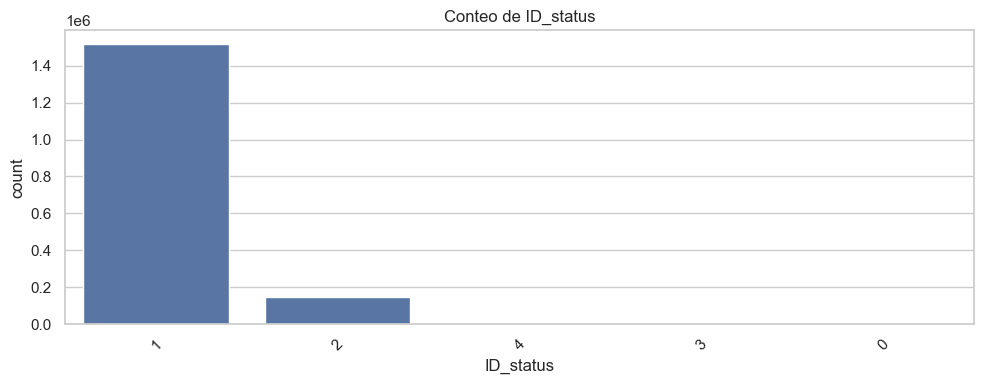

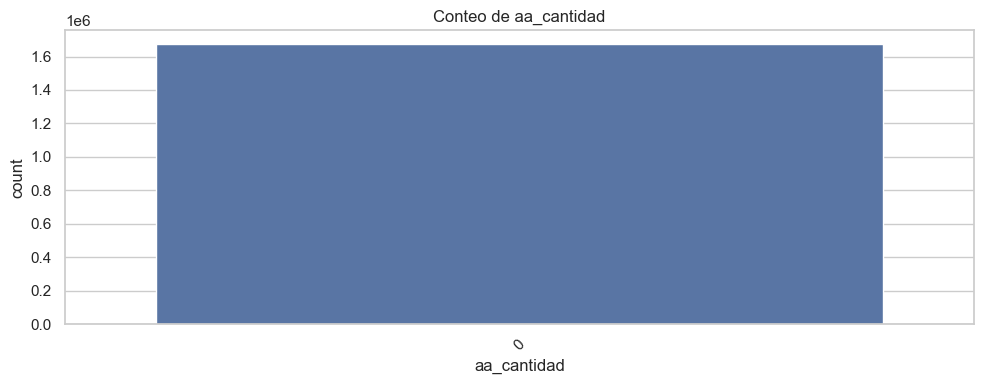

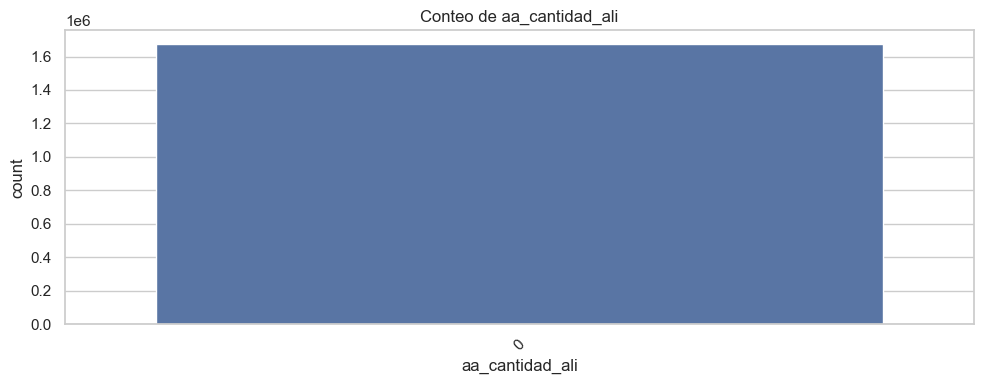

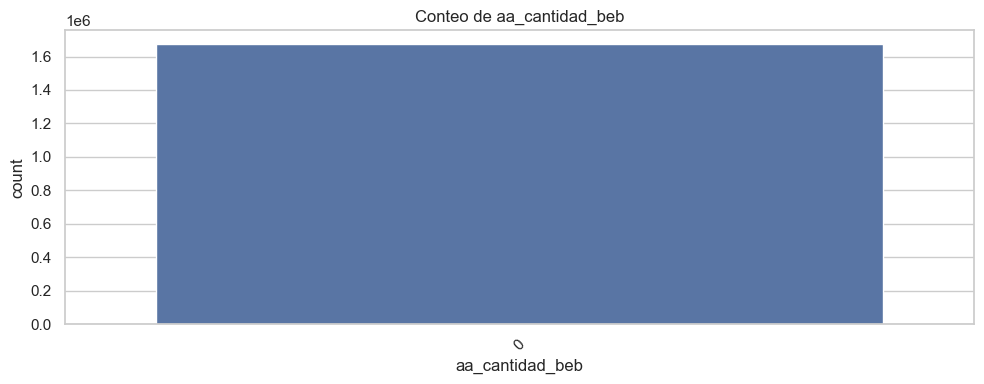

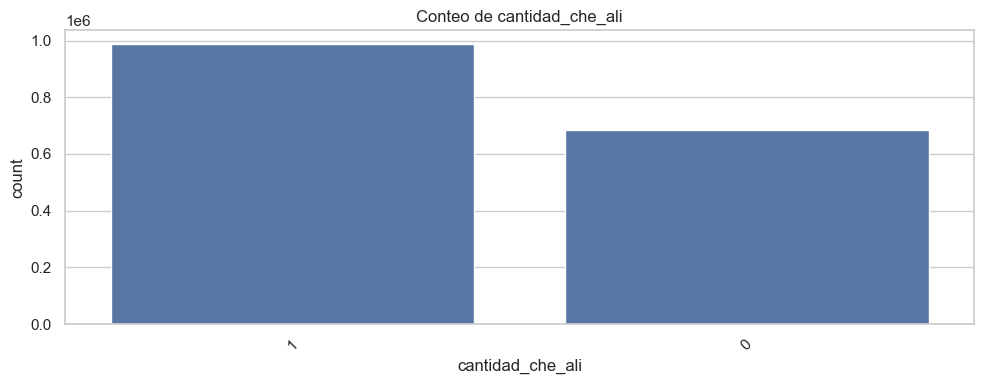

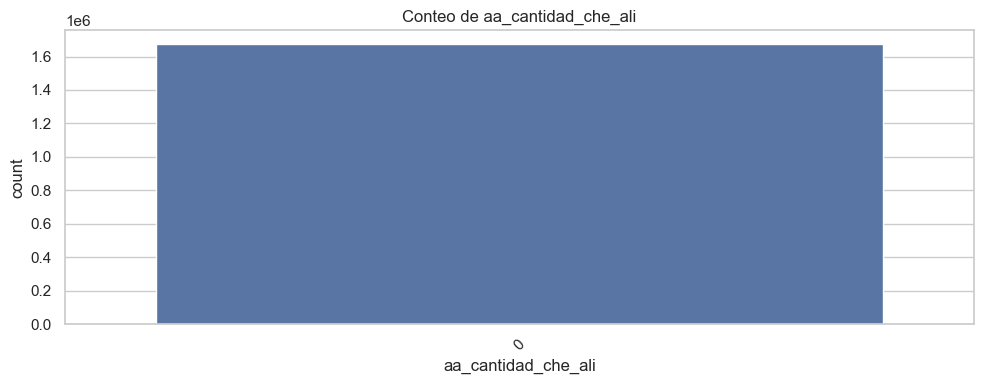

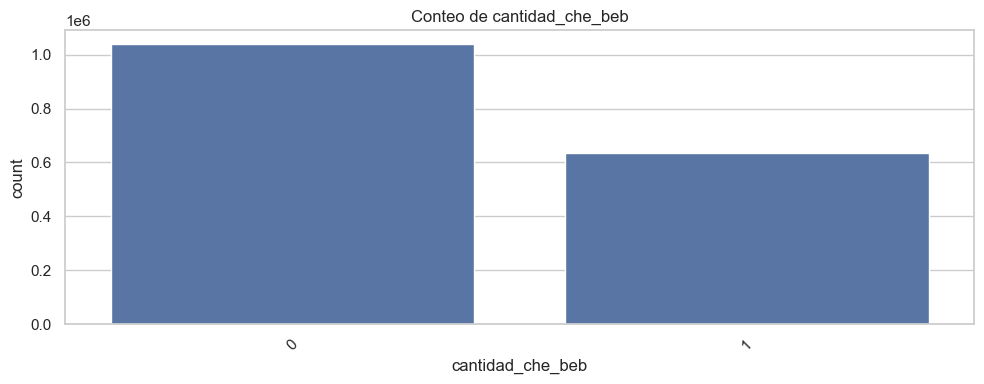

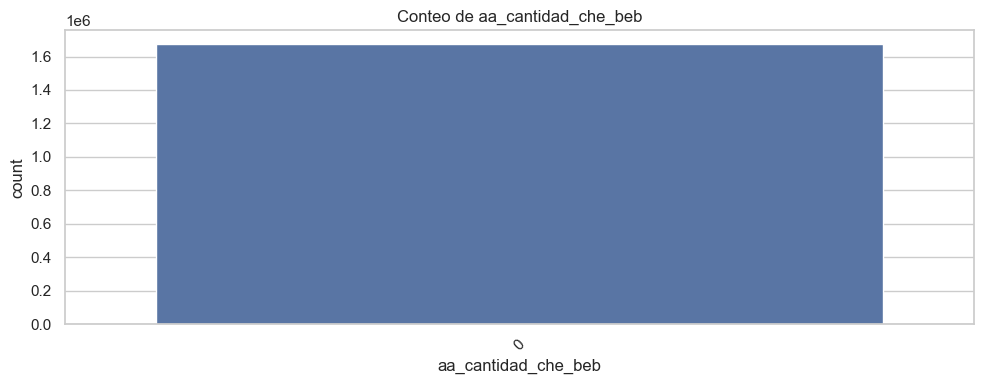

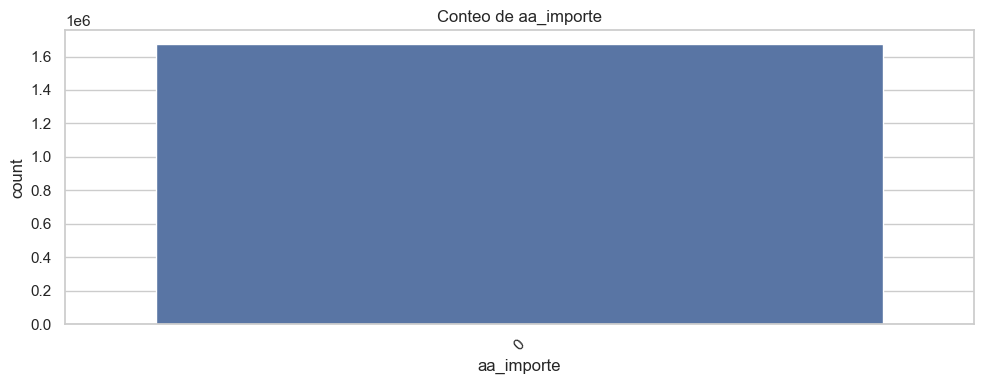

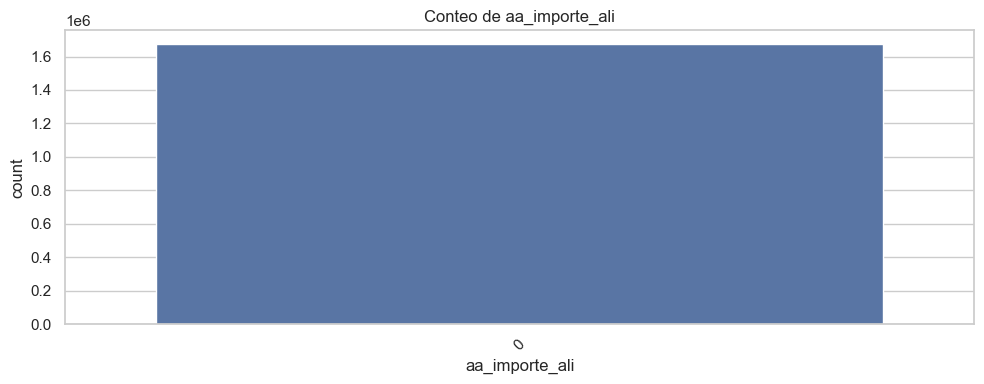

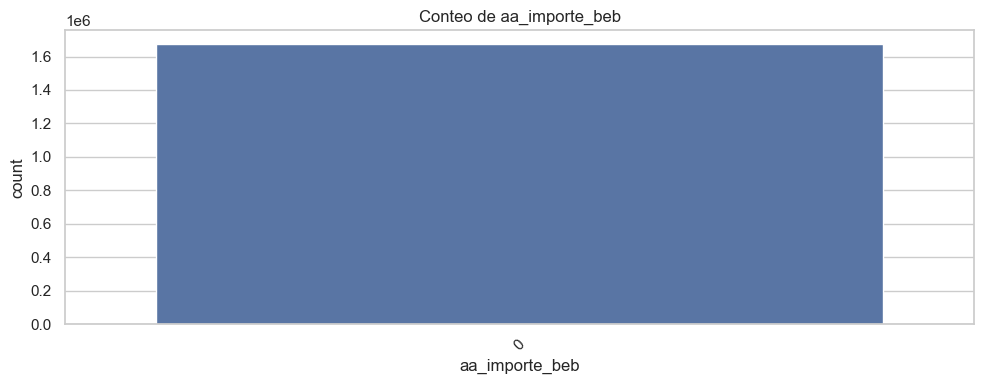

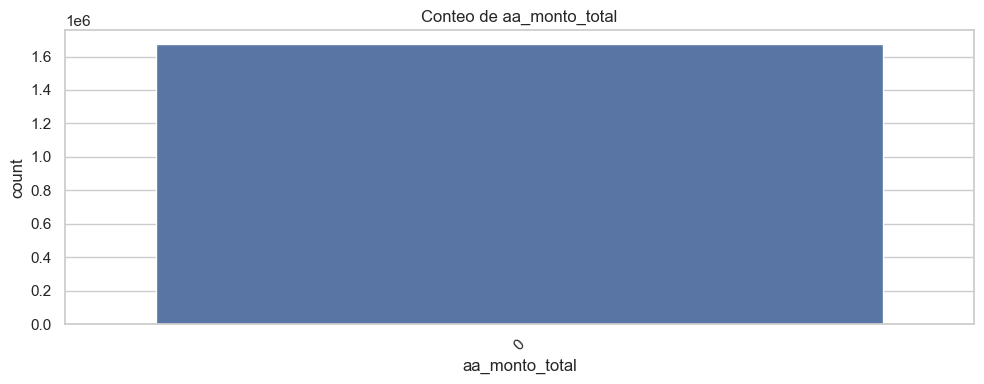

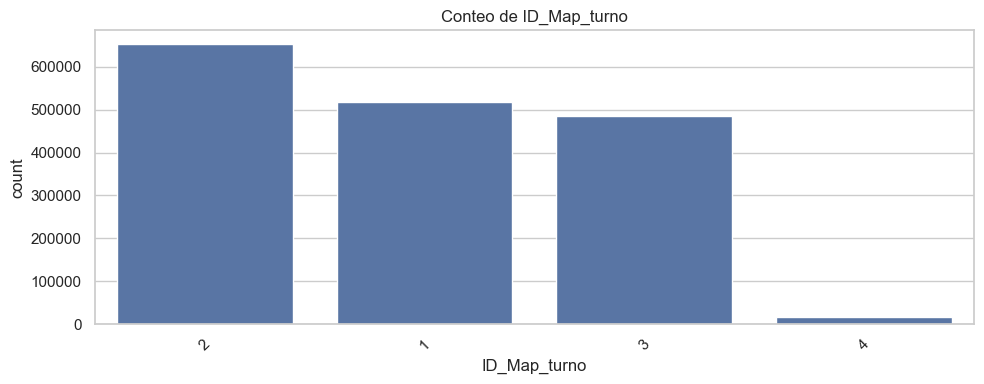

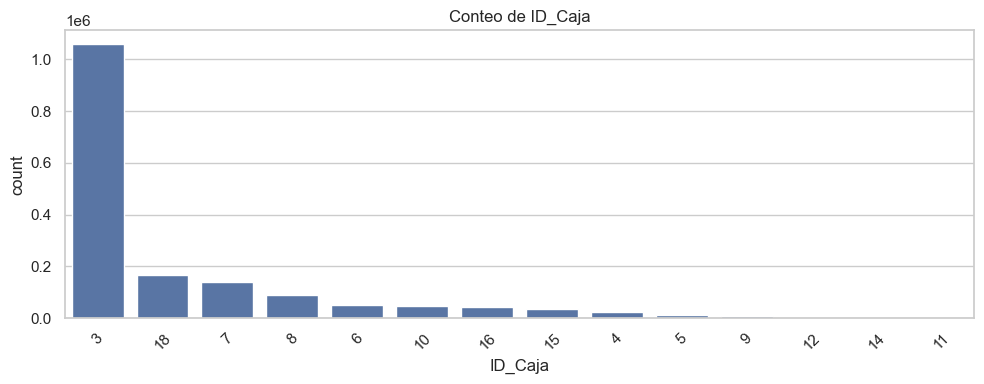

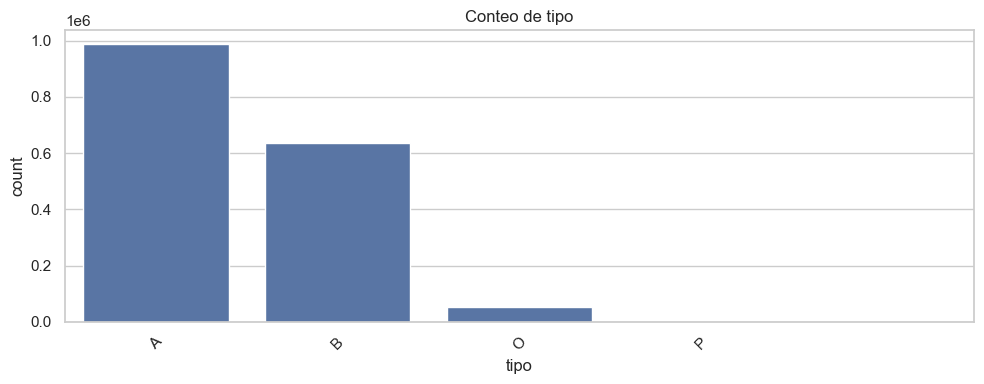

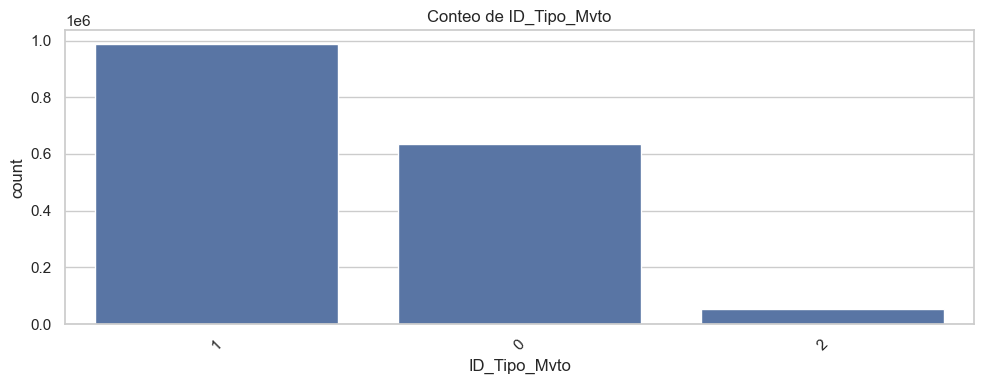

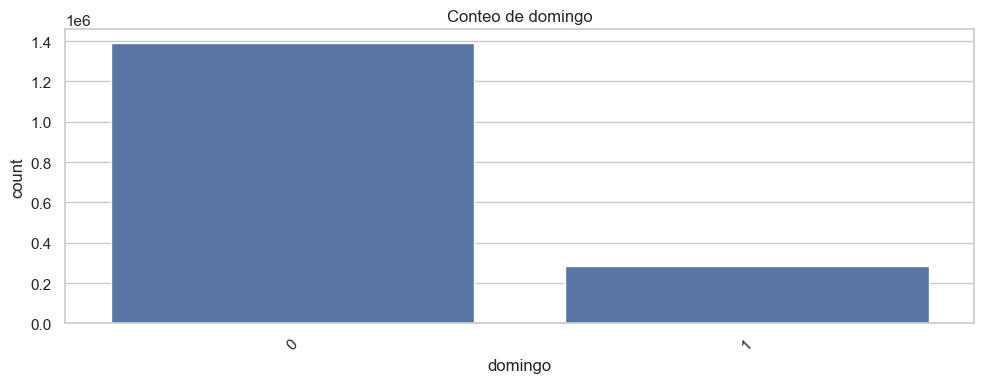

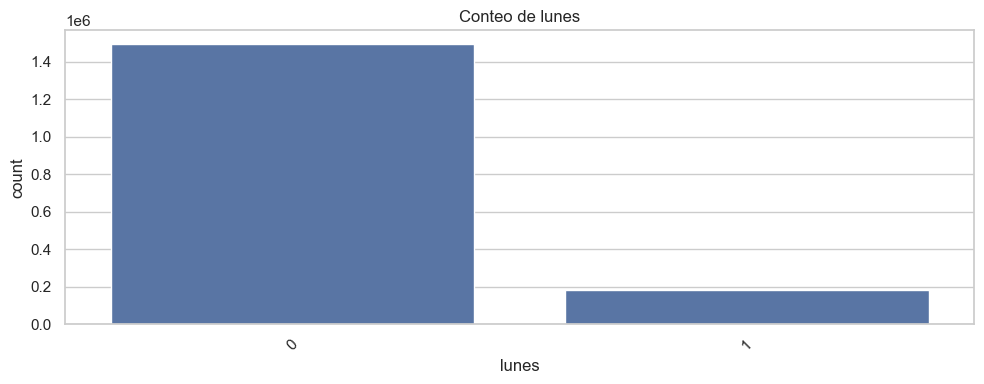

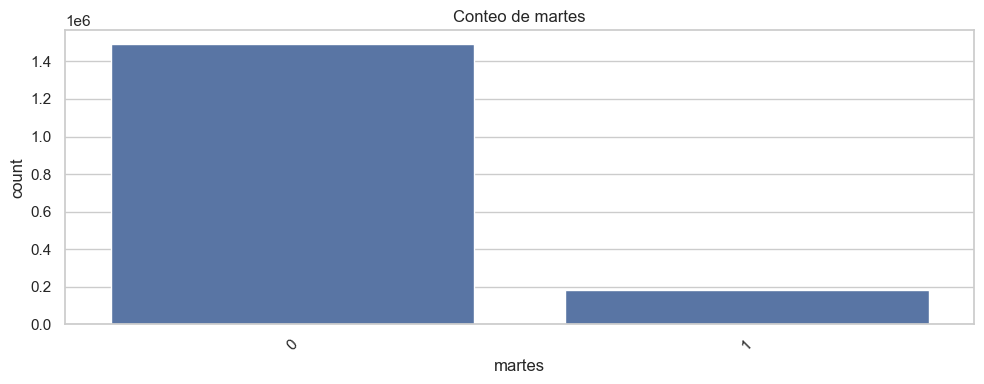

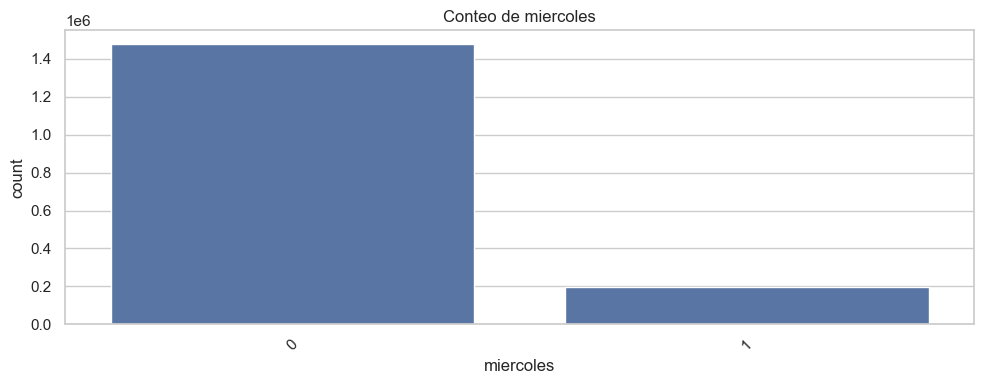

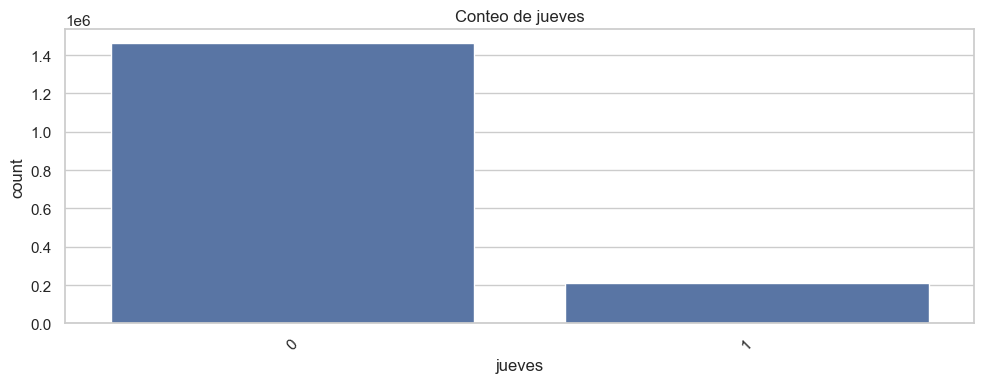

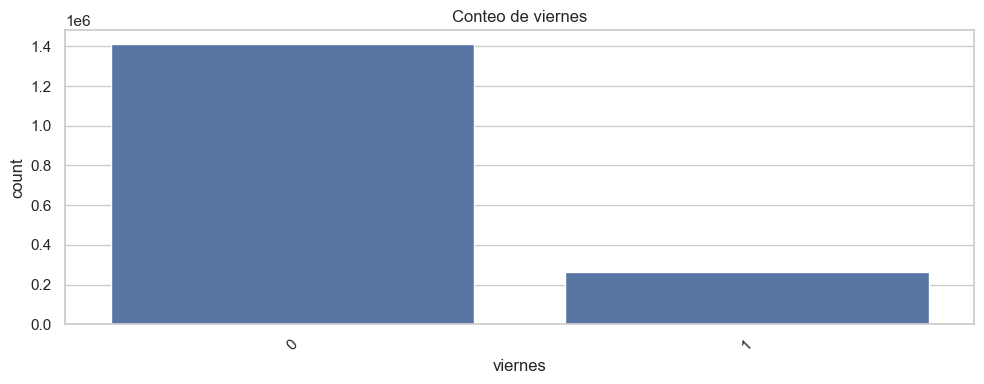

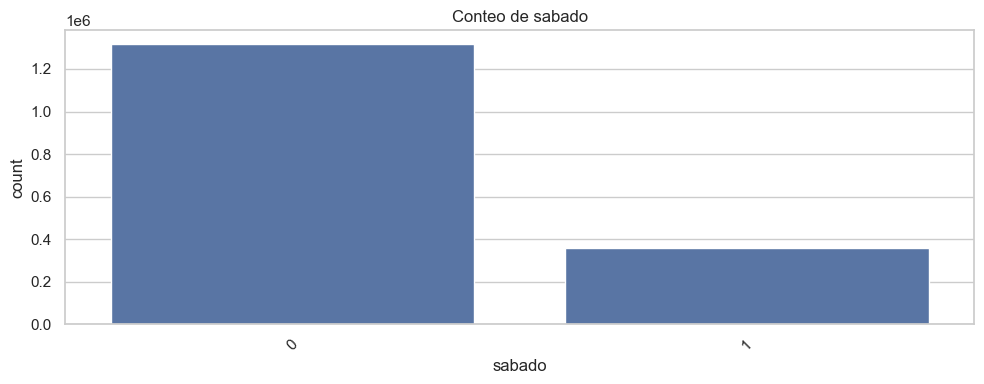

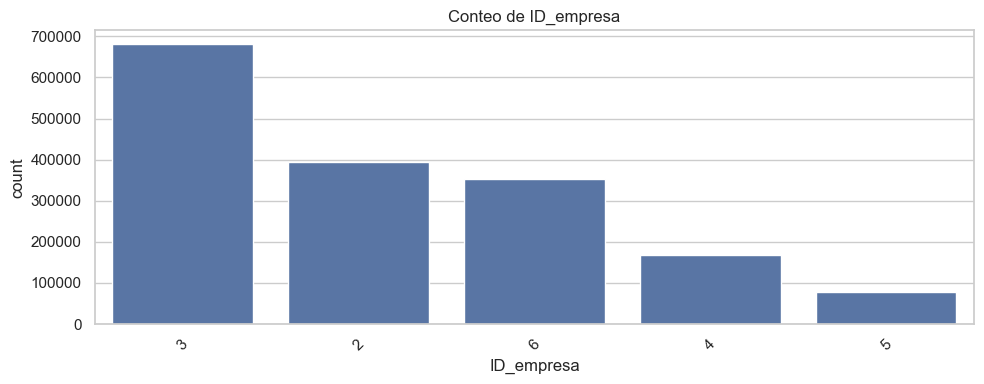

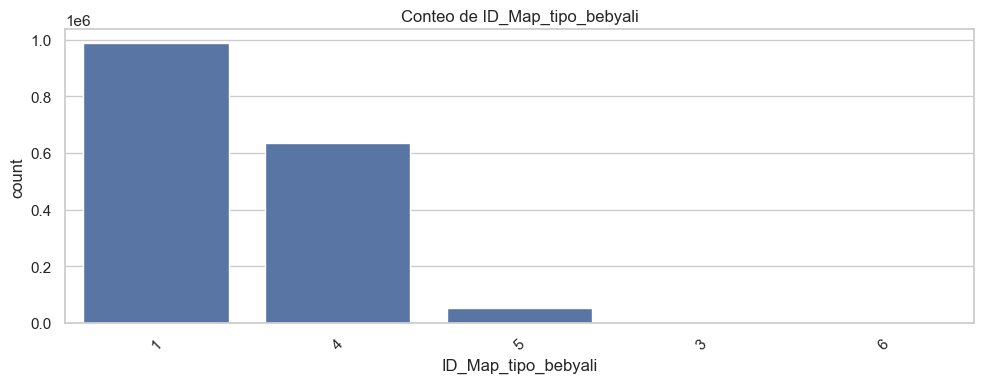

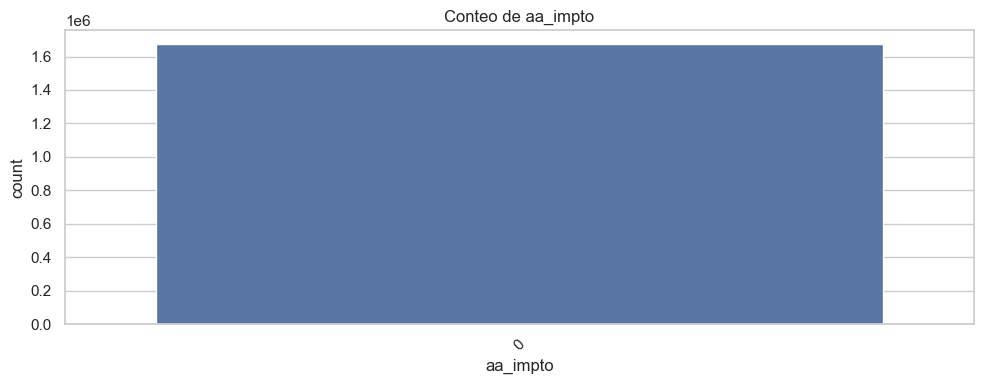

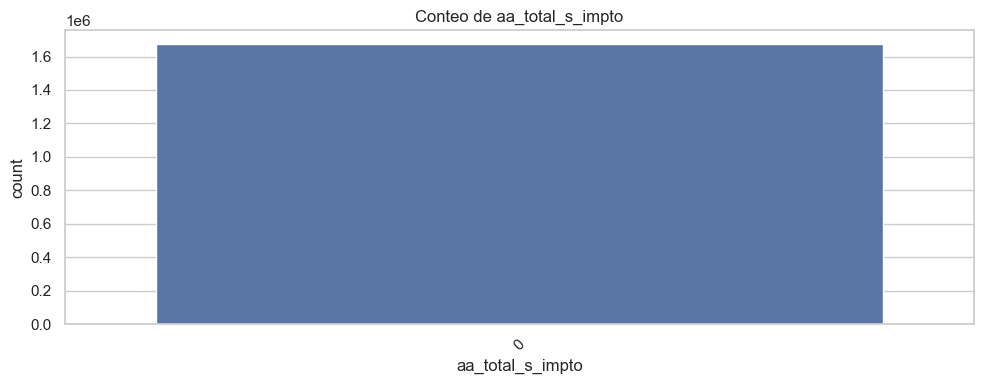

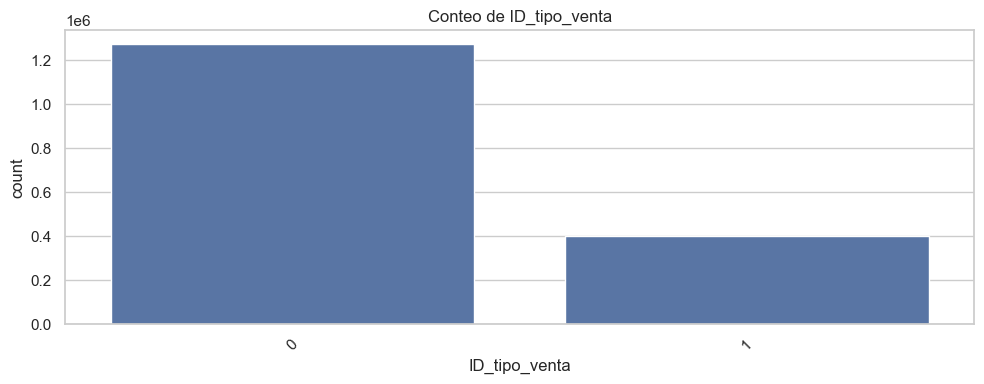

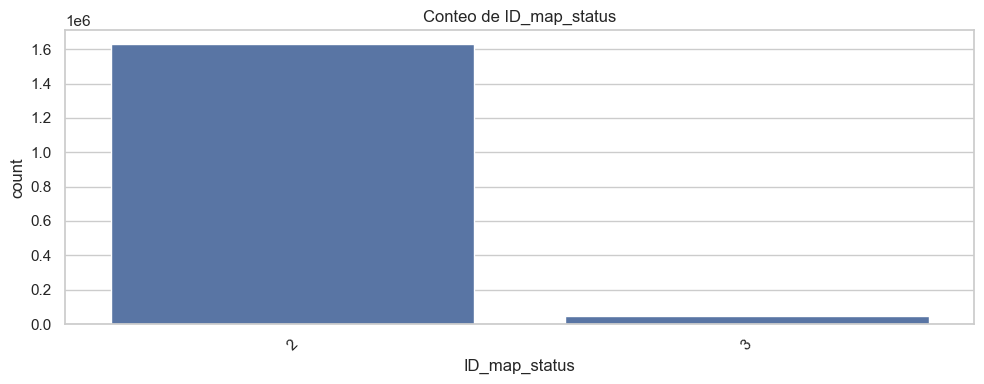

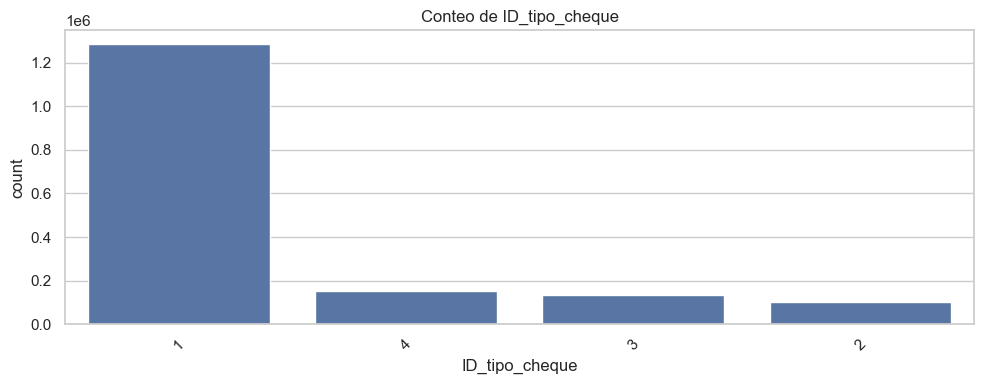

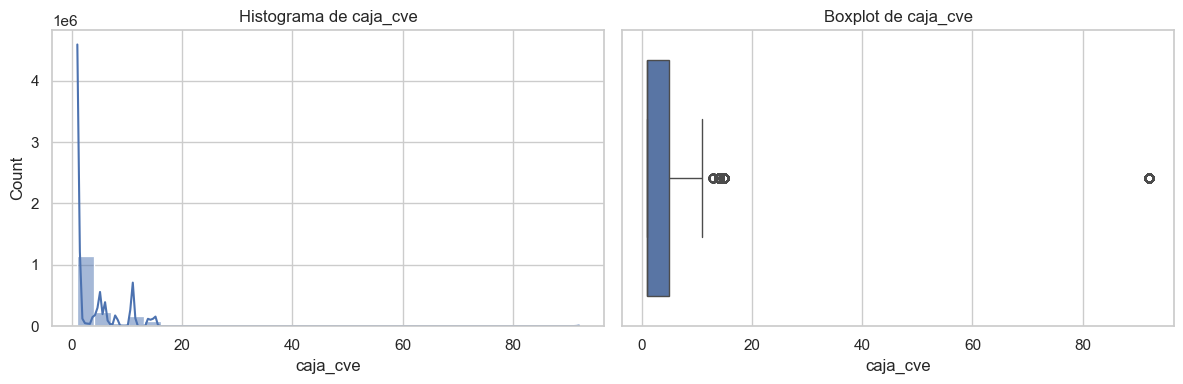

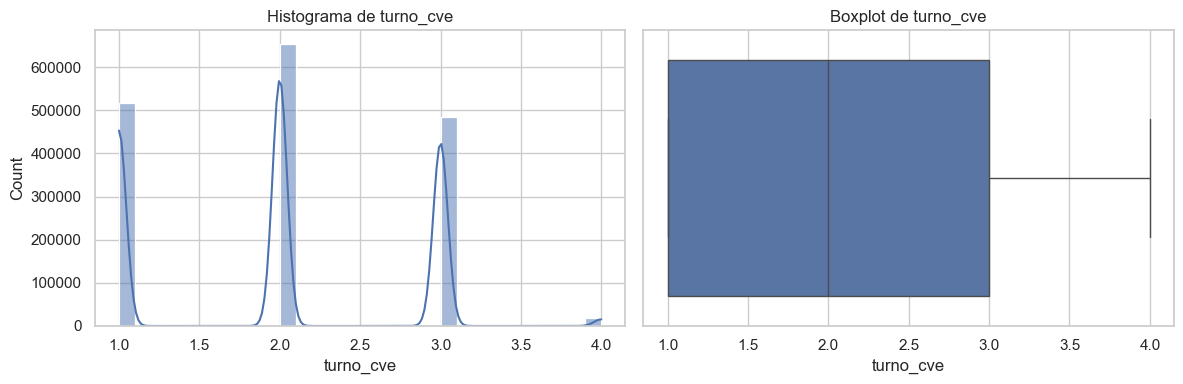

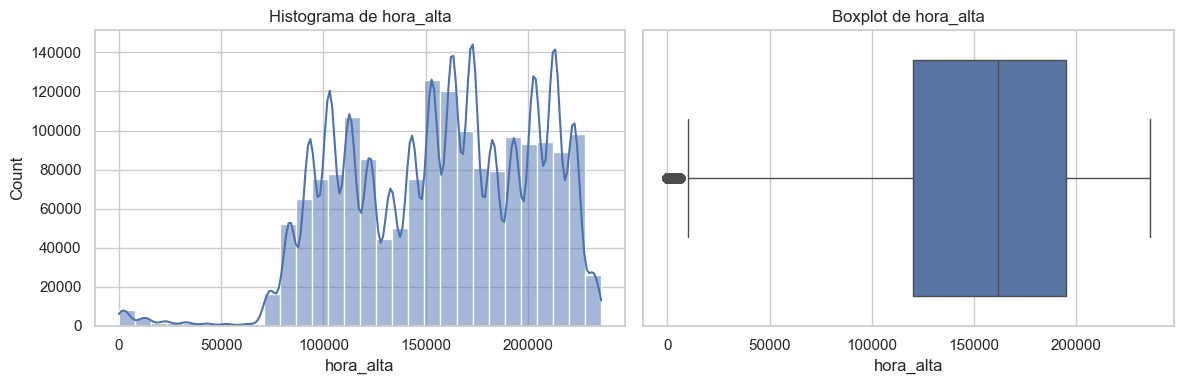

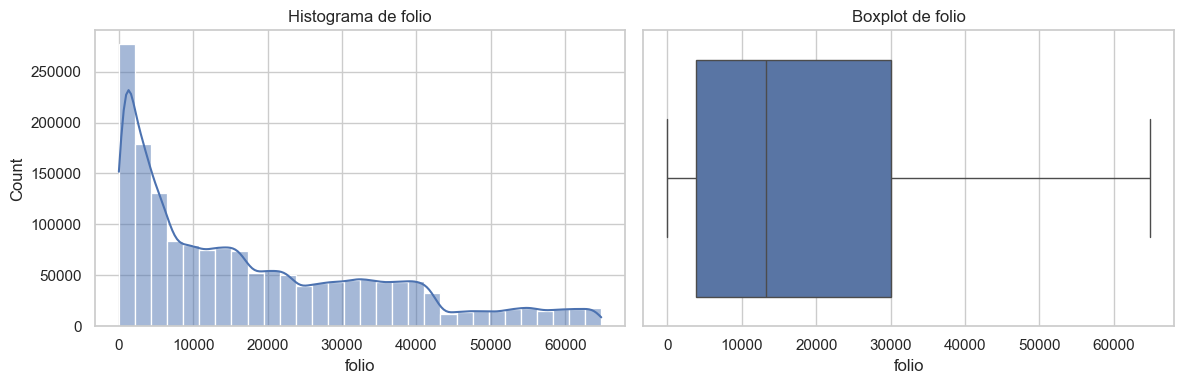

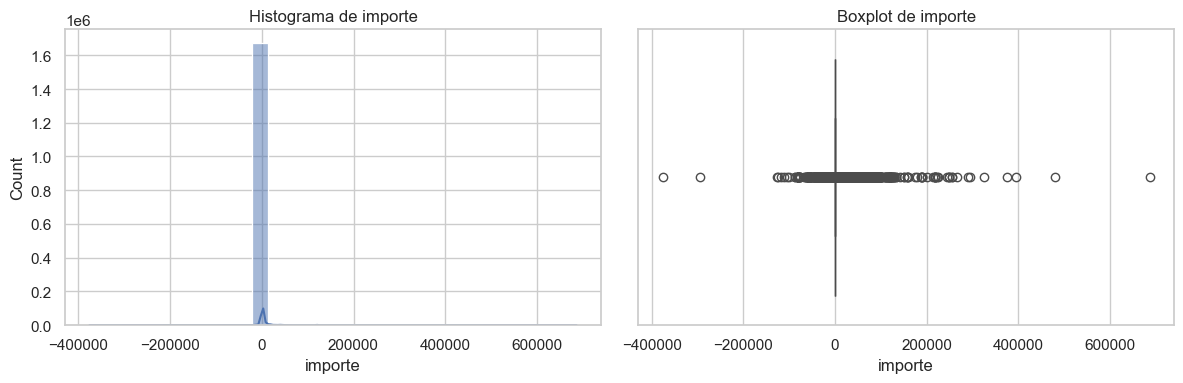

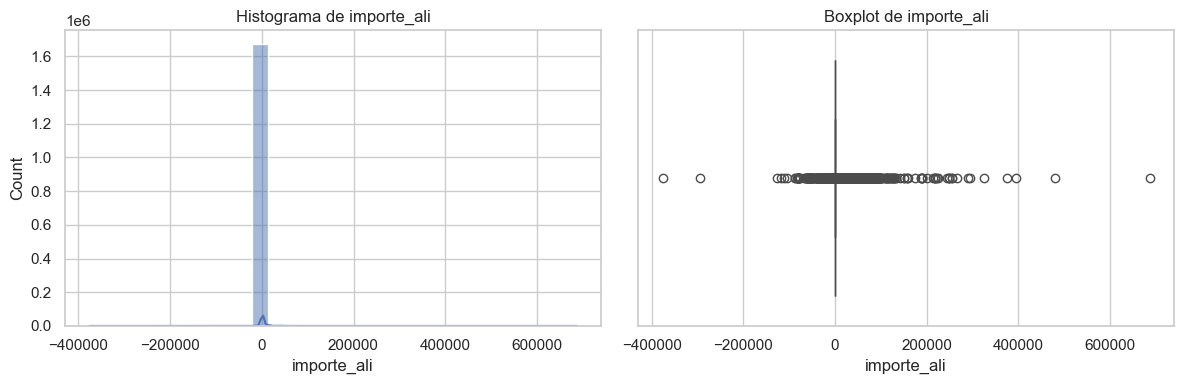

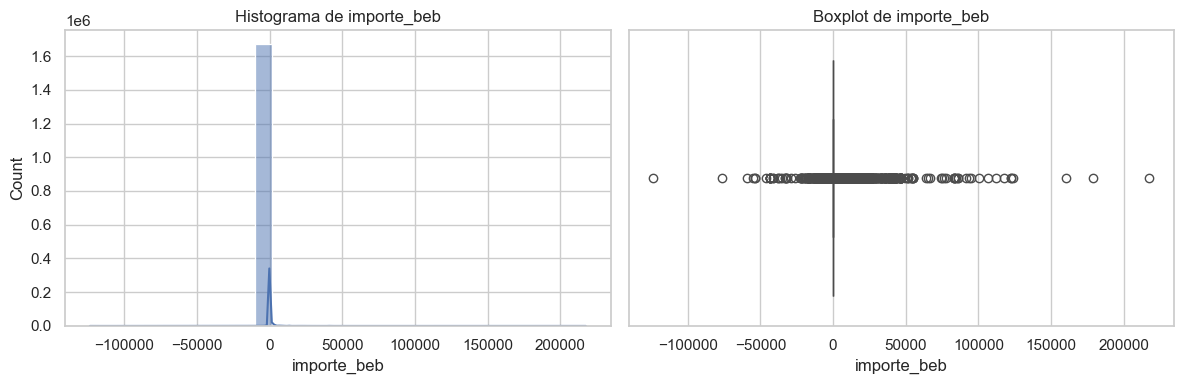

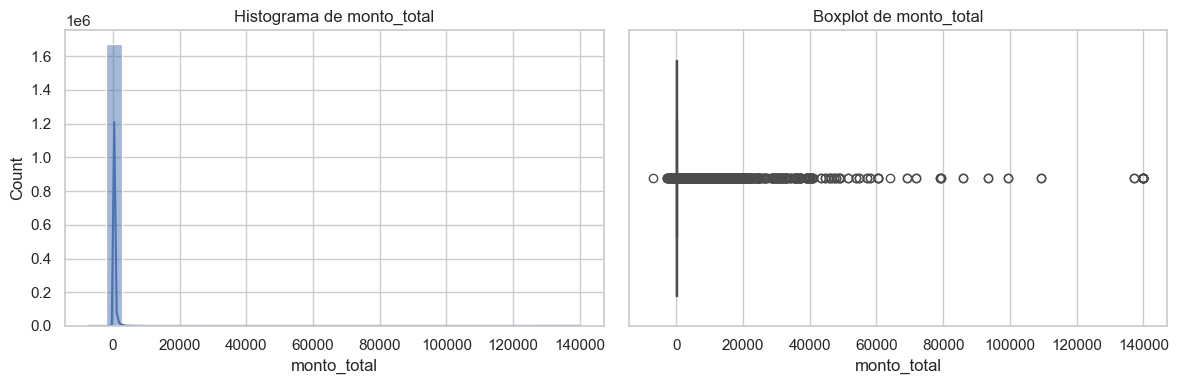

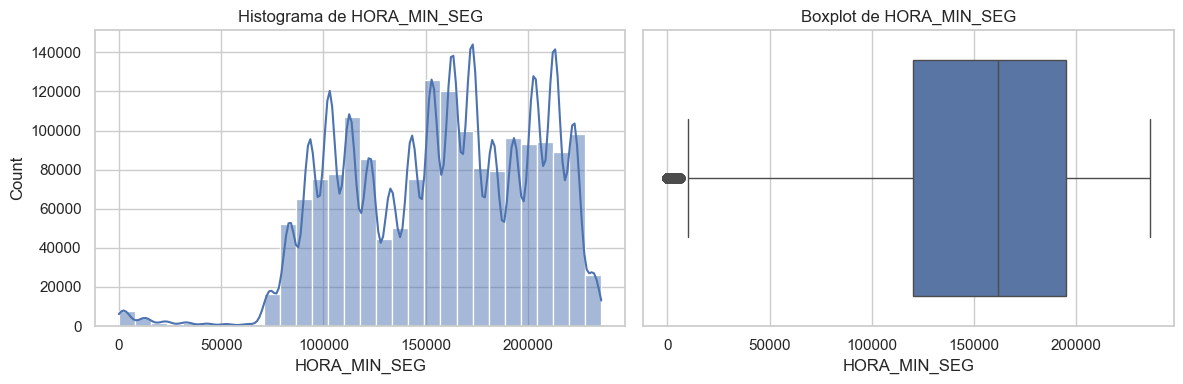

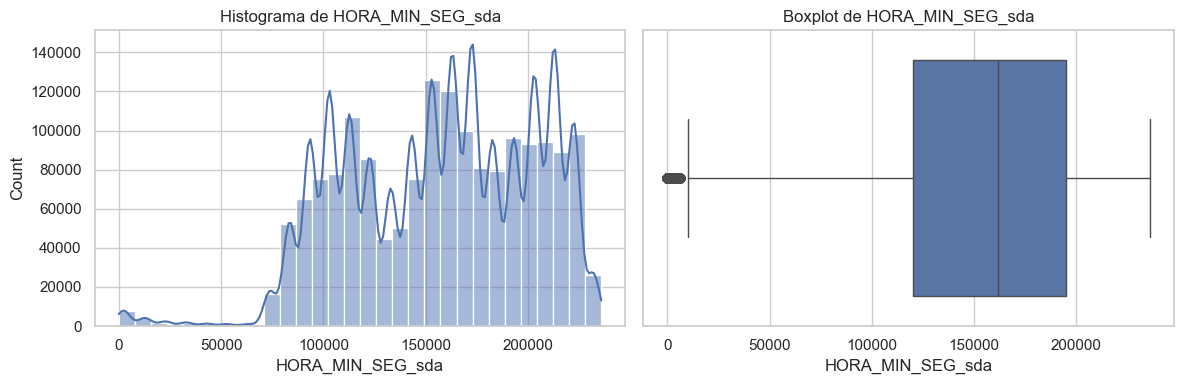

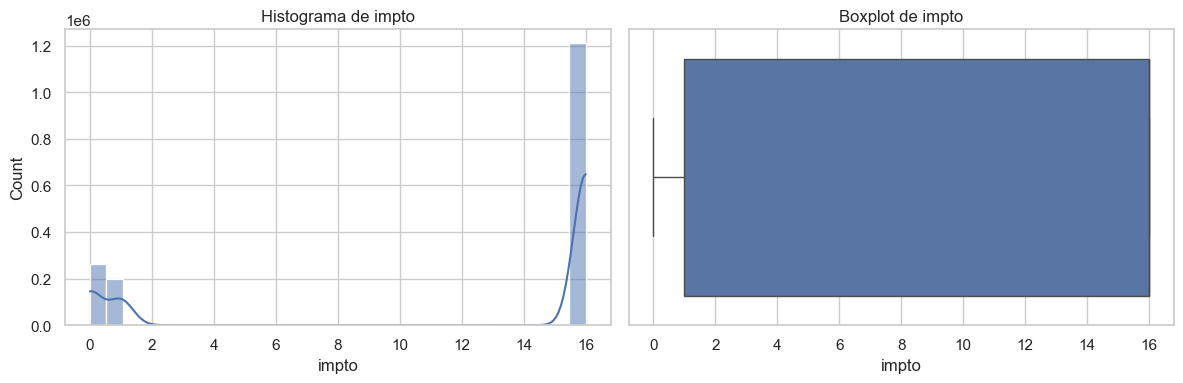

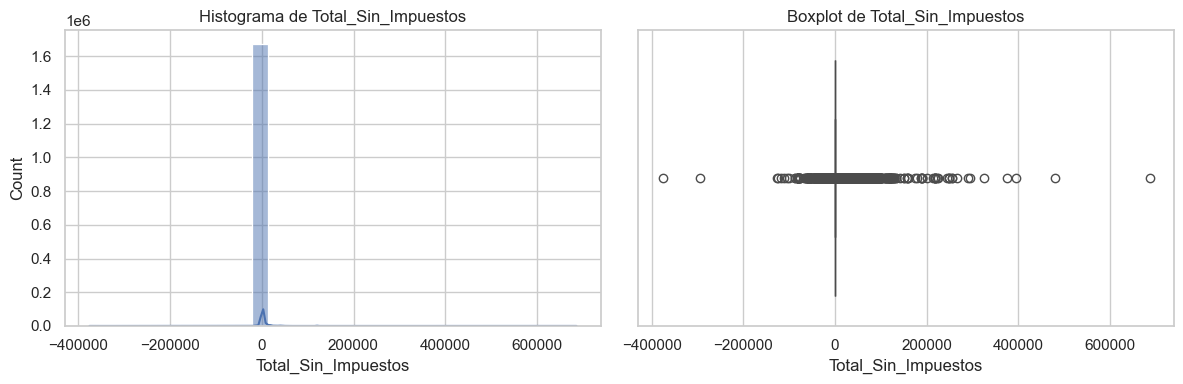

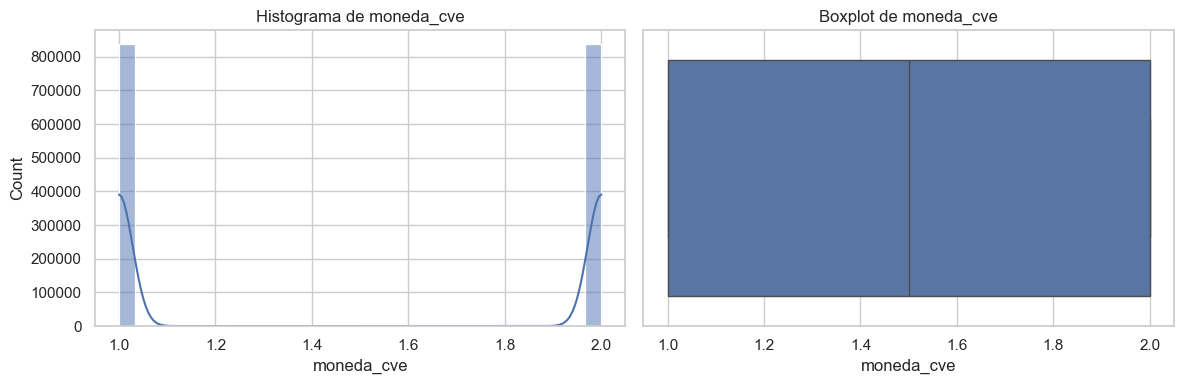

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


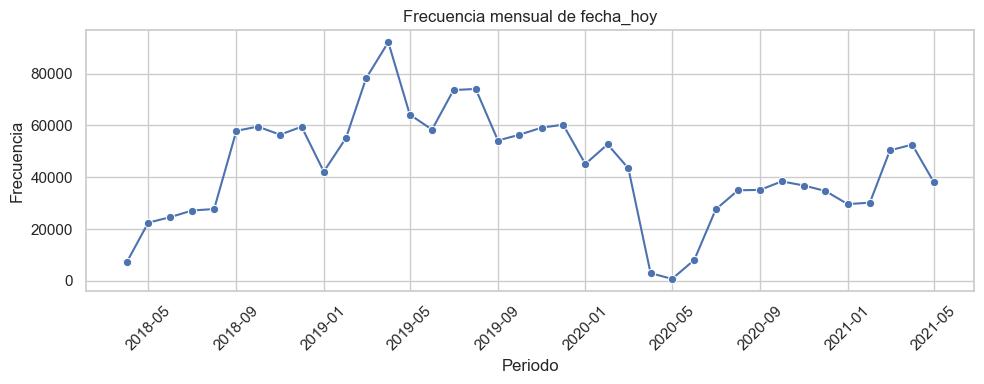

/var/folders/t1/gnq0y9p93x58rz8v61h7qpdh0000gn/T/ipykernel_41667/2726776292.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)


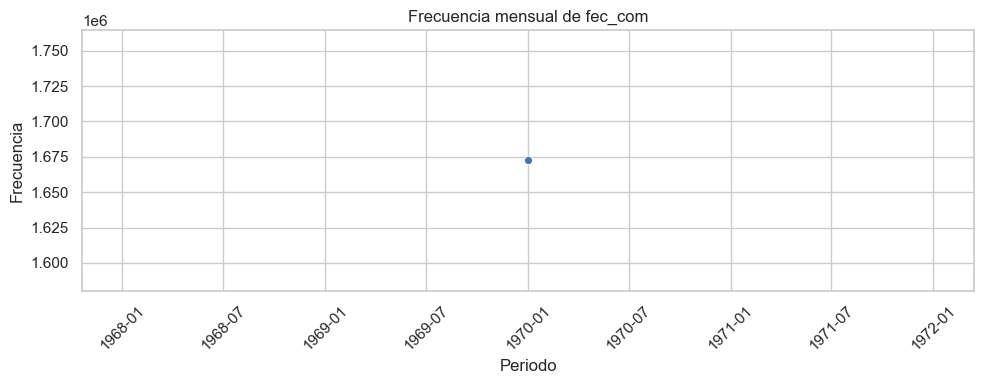

In [28]:
visualizar_columnas_por_tipo(detallesVtas, cols)